Previously, we have looked at what was the evolution as function of the time gap between two black holes. Here, we look at the consequence of the presence of a black hole somewhere in the inspiral of the neutron star

Before adding the BBH in the NS inspiral, we look at the technique that would enable to subract the signal out of it.

In [1]:
%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
#library

from pycbc.filter import highpass, sigma
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import matched_filter
import numpy as np



In [3]:
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()

In [4]:
strainL1 = strain['L1']
strainFL1 = stilde['L1']
idx = strainL1.numpy().argmax()
maxAmp = strainL1[idx]
maxAmpT = strainL1.sample_times[idx]
print(maxAmpT)

1187008881.3787599


(1e-47, 1e-42)

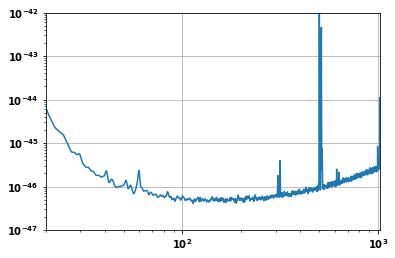

In [9]:
psd = strainL1.psd(2)
psd = interpolate(psd, strainL1.delta_f)
psd = inverse_spectrum_truncation(psd, 2*strainL1.sample_rate, 
                                 low_frequency_cutoff = 15.,
                                 trunc_method = 'hann')

plt.loglog(psd.sample_frequencies, psd)
plt.xlim(20,1024)
plt.grid()
plt.ylim(1e-47, 1e-42)

In [6]:
#test to find the signal in one detector only
mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax = None
maxsnr, m1max, m2max, tmax = 0, 0, 0, 0

snrs = [[] for i in range(len(mass1))]
max_snrs = [[] for i in range(len(mass1))]
times_max = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = strainFL1.delta_f)
        hp.resize(len(strainFL1))
        
        #do the max filtering
        snr = matched_filter(hp, strainFL1, psd = psd, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrs[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrs[i].append(snrp)
        time = snr.sample_times[idx]
        times_max[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnr:
            tmax, hmax, m1max, m2max, maxsnr = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1max, m2max, tmax, maxsnr))

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.9218268


In [7]:
print(merger.time)

1187008882.4


In [8]:
from pycbc.filter import sigma

dt = tmax - strainFL1.start_time
inj = hmax.cyclic_time_shift(dt)

#scaling of the template 
inj /= sigma(hmax, psd = psd, low_frequency_cutoff = 20.)
inj *= maxsnr

#subtraction
subL1F = strainFL1 - inj

#whiten
subT_white = (subL1F/psd**0.5).to_timeseries()
zoom = subT_white.time_slice(merger.time - 120, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange=(20,512),
                         qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the subtracted data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 110, merger.time + 10)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

(1187008872.4454103, 1187008892.4454103)

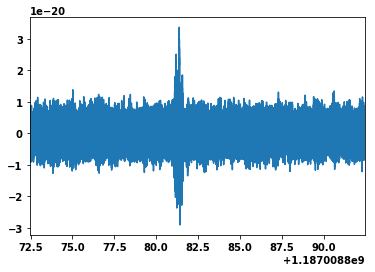

In [9]:
plt.plot(strainL1.sample_times, strainL1)
plt.xlim(tmax - 10, tmax + 10)

In [10]:
#NS signal modeled

from pycbc.waveform import get_td_waveform

hpNS, _ = get_td_waveform(approximant = 'SEOBNRv4T', mass1 = m1max, 
                         mass2 = m2max, f_lower = 20, 
                          delta_t = strainL1.delta_t)

hpNS.resize(len(strainL1))

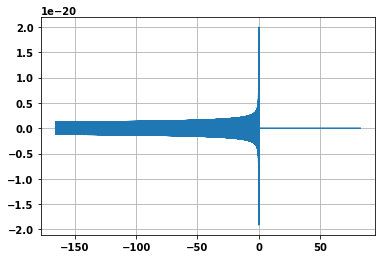

In [11]:
plt.plot(hpNS.sample_times, hpNS)
plt.grid()

In [12]:
ind = hpNS.numpy().argmax()
max_amp = hpNS[ind]

print(max_amp)

1.9939994271301906e-20


In [11]:
idx = strainL1.numpy().argmax()
maxAmp = strainL1[idx]
maxAmpT = strainL1.sample_times[idx]
print(maxAmpT)

1187008881.3787599


In [14]:
#make BH signal with a comparable amplitude at the time of ther merger

distances = np.arange(100, 5000, 100)

hpBH = None
amp_maxBH = 0

for dist in distances:
    hp, _ = get_td_waveform(approximant = 'SEOBNRv4', mass1 = 50,
                           mass2 = 50, distance = dist, f_lower = 20.,
                           delta_t = strainL1.delta_t)
    hp.resize(len(strainL1))
    
    idx = hp.numpy().argmax()
    amp = hp[idx]
    
    print(amp)
    
    if(abs(amp - max_amp) < 1e-20):
        hpBH = hp
        amp_maxBH = amp

1.1708962703593002e-20
5.854481351796501e-21
3.902987567864335e-21
2.9272406758982505e-21
2.341792540718601e-21
1.9514937839321674e-21
1.6727089576561432e-21
1.4636203379491252e-21
1.3009958559547782e-21
1.1708962703593005e-21
1.0644511548720911e-21
9.757468919660837e-22
9.006894387379234e-22
8.363544788280716e-22
7.80597513572867e-22
7.318101689745626e-22
6.887625119760591e-22
6.504979279773891e-22
6.1626119492594745e-22
5.8544813517965025e-22
5.575696525520478e-22
5.322255774360456e-22
5.090853349388263e-22
4.878734459830418e-22
4.683585081437202e-22
4.503447193689617e-22
4.336652853182594e-22
4.181772394140358e-22
4.037573346066553e-22
3.902987567864335e-22
3.7770847430945175e-22
3.659050844872813e-22
3.548170516240304e-22
3.4438125598802954e-22
3.345417915312287e-22
3.2524896398869456e-22
3.164584514484596e-22
3.0813059746297373e-22
3.0022981291264115e-22
2.9272406758982512e-22
2.855844561851952e-22
2.787848262760239e-22
2.7230145822309316e-22
2.661127887180228e-22
2.60199171190955

In [15]:
print(amp_maxBH)

1.1708962703593002e-20


Text(0.5,1,'Comparison of the neutron stars merger and black holes merger signals')

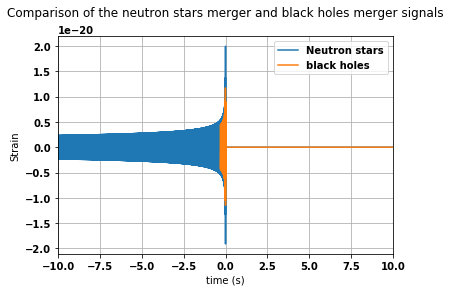

In [16]:
#plot the BH signal and NS sigbal on same plot to check amplitude

plt.plot(hpNS.sample_times, hpNS, label='Neutron stars')
plt.plot(hpBH.sample_times, hpBH, label='black holes')

plt.grid()
plt.legend(loc='best')

plt.xlim(-10, 10)
plt.ylabel("Strain")
plt.xlabel("time (s)")
plt.title("Comparison of the neutron stars merger and black holes merger signals", pad = 20)

The amplitudes are comparable. Now, we can see how the SNR evolves depending on where the black hole signa is present. 

For each separation, we look at the possibility to find the black hole signal first or the neutron star merger first.

## For a 110s gap

We look at the possibility to find both for 110 s gap. This should not be a problem as the black holes would impact, at maximum, the start of the NS merger.

We will take the difference between both max and not merger time because there is a 1s gap between both

In [17]:
print(maxAmpT, merger.time)

(1187008881.3787599, 1187008882.4)


In [18]:
time_shifts = np.arange(1, 200, 0.2)

modelBH = None
maxAmpBH, timeBH, time_dif = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - maxAmpT
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (abs(timeDif) < 110.5) and (abs(timeDif) > 109.5) :
        print("in loop")
        modelBH = hpInj
        maxAmpBH, timeBH, time_dif = max_amp, time_inj, timeDif

in loop
in loop
in loop
in loop
in loop


In [19]:
print(maxAmpT)

1187008881.3787599


In [20]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH)
print("The time of this maximum is: ", time_inj)
print("The time of the meger is: ", merger.time-1)
print("The time difference is: ", time_dif)

('The maximum amplitude of the injection is: ', 6.893045907403019e-21)
('The time of this maximum is: ', 1187008863.045508)
('The time of the meger is: ', 1187008881.4)
('The time difference is: ', -109.533203125)


In [21]:
print(time_inj - merger.time)

-19.3544921875


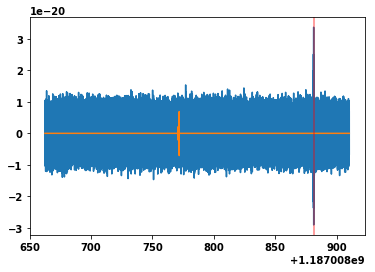

In [22]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH.sample_times, modelBH, label = 'injection')
plt.axvline(maxAmpT, color = 'red', alpha = 0.5)

The time difference when compted seems wrong. However, when the comparison is done, one sees that the injection appears at the correct place.

So we try to retrieve the NS and the BH signal, the one after the other

In [23]:
#addition of the two signals

sig = strainL1 + modelBH

sigF = sig.to_frequencyseries()

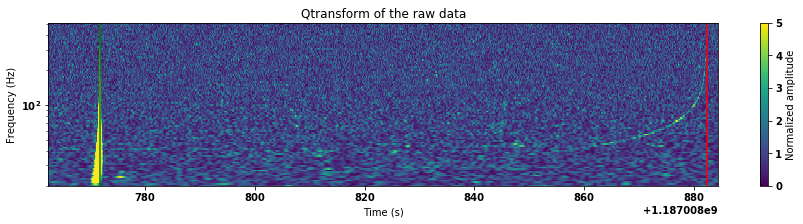

In [24]:
#qtransformm of the data
white_sig = (sigF/psd**0.5).to_timeseries()
zoom = white_sig.time_slice(merger.time - 120, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 120, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.axvline(merger.time, color = 'red')
plt.axvline(timeBH, color = 'green')

We see that the signal is well injected in the problem. Now, we can look at the possibility to retrieve it out of the data

In [25]:
#psd of the added signal

pA = sig.psd(2)
pA = interpolate(pA, sig.delta_f)
psdA = inverse_spectrum_truncation(pA, 2*sig.sample_rate,
                                  low_frequency_cutoff = 20.)

In [26]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA = None
maxsnrA, m1maxA, m2maxA, tmaxA = 0, 0, 0, 0

snrsA = [[] for i in range(len(mass1))]
max_snrsA = [[] for i in range(len(mass1))]
times_maxA = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF.delta_f)
        hp.resize(len(sigF))
        
        #do the max filtering
        snr = matched_filter(hp, sigF, psd = psdA, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA:
            tmaxA, hmaxA, m1maxA, m2maxA, maxsnrA = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA, m2maxA, tmaxA, maxsnrA))

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.9664274


In [27]:
print(merger.time)
print(timeBH)

1187008882.4
1187008771.8455567


(1187008762.4, 1187008884.4)

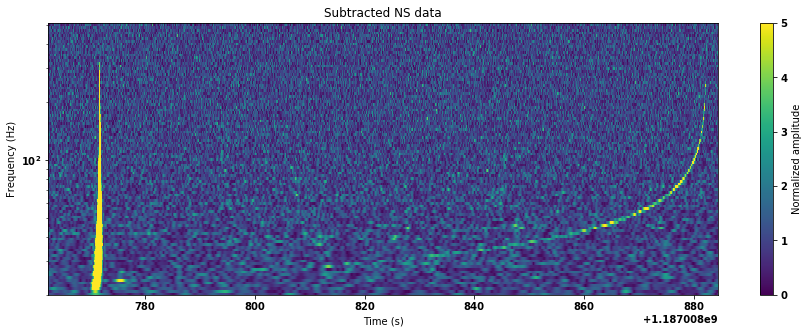

In [28]:
from pycbc.filter import sigma

dt = tmaxA - sigF.start_time
inj = hmaxA.cyclic_time_shift(dt)

inj/= sigma(hmaxA, psd = psdA, low_frequency_cutoff = 20.)
inj *= maxsnrA

subF = sigF - inj

subT_w = (subF/psdA**0.5).to_timeseries()
zoom = subT_w.time_slice(merger.time - 120, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 120, merger.time +2)

The subtraction in this case is not really well done. However, we do not have the possibility to do the adjustement to enable the subtraction, due to the lenght of the signal. However, we see that the parameters that are retrieved are still plausible.

Now, we look at the possibility to find the black hole merger

In [29]:
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB = None
maxsnrB, m1maxB, m2maxB, tmaxB = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF.delta_f)
        hp.resize(len(sigF))
        
        snr = matched_filter(hp, sigF, psd = psdA, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB:
            tmaxB, hmaxB, m1maxB, m2maxB, maxsnrB = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB, m2maxB, tmaxB, maxsnrB))
print(timeBH)

mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 30.00, m2 = 30.10 at time 1187008771.8514161 with a value 181.0481219
1187008771.8455567


The parameters and time of the events that are found are correct. We do not do the subtraction because it requires the fitting of the data, which is not feasible for such a long signal

## For 50 seconds gap
Here, the black hole merger will already be present in the tail of the inspiral. We will look at the effect it can have on the result

In [30]:
#download the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()

strainL1 = strain['L1']
strainFL1 = stilde['L1']


In [36]:
time_shifts = np.arange(1, 200, 0.2)

modelBH50 = None
maxAmpBH50, timeBH50, time_dif50 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - maxAmpT
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (abs(timeDif) < 50.5) and (abs(timeDif) > 49.5) :
        print("in loop")
        modelBH50 = hpInj
        maxAmpBH50, timeBH50, time_dif50 = max_amp, time_inj, timeDif

in loop
in loop
in loop
in loop
in loop


In [37]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH50)
print("The time of this maximum is: ", timeBH50)
print("The time of the meger is: ", merger.time - 1)
print("The time difference is: ", time_dif50)

('The maximum amplitude of the injection is: ', 6.89304590740683e-21)
('The time of this maximum is: ', 1187008831.8455567)
('The time of the meger is: ', 1187008881.4)
('The time difference is: ', -49.533203125)


In [38]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH50.sample_times, modelBH50, label = 'injection')
plt.axvline(maxAmpT, color = 'red', alpha = 0.5)


In [39]:
#addition of the two signals

sig50 = strainL1 + modelBH50

sigF50 = sig50.to_frequencyseries()

In [40]:
#psd of the added signal

pA50 = sig50.psd(2)
pA50 = interpolate(pA50, sig50.delta_f)
psdA50 = inverse_spectrum_truncation(pA50, 2*sig50.sample_rate,
                                  low_frequency_cutoff = 20.)

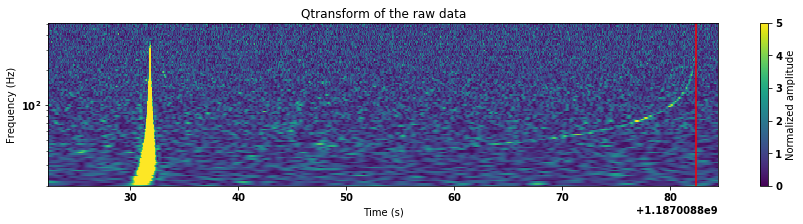

In [41]:
#qtransformm of the data
white_sig50 = (sigF50/psdA50**0.5).to_timeseries()
zoom = white_sig50.time_slice(merger.time - 60, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 60, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")
plt.axvline(merger.time, color = 'red')
plt.axvline(timeBH, color = 'green')


In [44]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA50 = None
maxsnrA50, m1maxA50, m2maxA50, tmaxA50 = 0, 0, 0, 0

snrsA50 = [[] for i in range(len(mass1))]
max_snrsA50 = [[] for i in range(len(mass1))]
times_maxA50 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF50.delta_f)
        hp.resize(len(sigF50))
        
        #do the max filtering
        snr = matched_filter(hp, sigF50, psd = psdA50, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA50[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA50[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA50[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA50:
            tmaxA50, hmaxA50, m1maxA50, m2maxA50, maxsnrA50 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA50, m2maxA50, tmaxA50, maxsnrA50))
print(merger.time)
print(timeBH50)


Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.3279151
1187008882.4
1187008831.8455567


(1187008822.4, 1187008884.4)

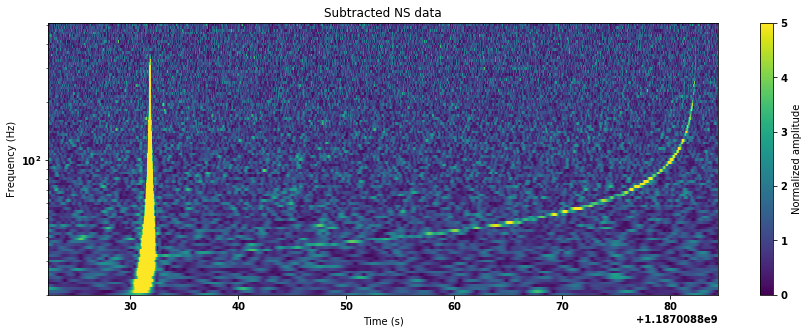

In [45]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA50 - sigF50.start_time
inj = hmaxA50.cyclic_time_shift(dt)

inj/= sigma(hmaxA50, psd = psdA50, low_frequency_cutoff = 20.)
inj *= maxsnrA50

subF50 = sigF50 - inj

subT_w50 = (subF50/psdA50**0.5).to_timeseries()
zoom = subT_w50.time_slice(merger.time - 60, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 60, merger.time +2)


In [46]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB50 = None
maxsnrB50, m1maxB50, m2maxB50, tmaxB50 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF50.delta_f)
        hp.resize(len(sigF50))
        
        snr = matched_filter(hp, sigF50, psd = psdA50, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB50:
            tmaxB50, hmaxB50, m1maxB50, m2maxB50, maxsnrB50 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB50, m2maxB50, tmaxB50, maxsnrB50))
print(timeBH50)



mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 30.10, m2 = 30.10 at time 1187008831.8514161 with a value 182.2521541
1187008831.8455567


We see that in this situation, the parameters found for both events are still in agreement with those used at the start.

## For a 25s gap

In [3]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()

strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [13]:
time_shifts = np.arange(1, 200, 0.2)

modelBH25 = None
maxAmpBH25, timeBH25, time_dif25 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - maxAmpT
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (abs(timeDif) < 25.5) and (abs(timeDif) > 24.5) :
        print("in loop")
        modelBH25 = hpInj
        maxAmpBH25, timeBH25, time_dif25 = max_amp, time_inj, timeDif

in loop
in loop
in loop
in loop
in loop


In [14]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH25)
print("The time of this maximum is: ", timeBH25)
print("The time of the meger is: ", merger.time-1)
print("The time difference is: ", time_dif25)

('The maximum amplitude of the injection is: ', 6.893045907395932e-21)
('The time of this maximum is: ', 1187008856.8455567)
('The time of the meger is: ', 1187008881.4)
('The time difference is: ', -24.533203125)


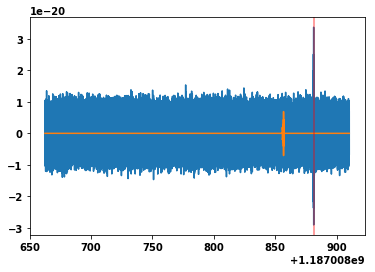

In [15]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH25.sample_times, modelBH25, label = 'injection')
plt.axvline(maxAmpT, color = 'red', alpha = 0.5)

In [17]:
#addition of the two signals

sig25 = strainL1 + modelBH25

sigF25 = sig25.to_frequencyseries()

In [18]:
pA25 = sig25.psd(2)
pA25 = interpolate(pA25, sig25.delta_f)
psdA25 = inverse_spectrum_truncation(pA25, 2*sig25.sample_rate,
                                  low_frequency_cutoff = 20.)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

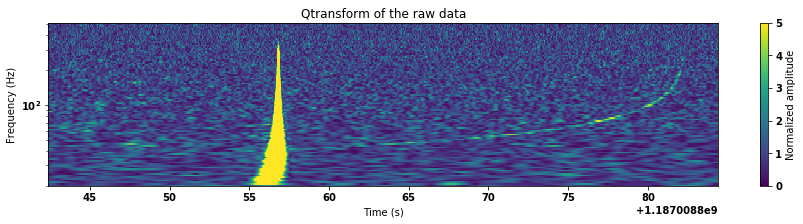

In [19]:
#qtransformm of the data
white_sig25 = (sigF25/psdA25**0.5).to_timeseries()
zoom = white_sig25.time_slice(merger.time - 50, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 40, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [20]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA25 = None
maxsnrA25, m1maxA25, m2maxA25, tmaxA25 = 0, 0, 0, 0

snrsA25 = [[] for i in range(len(mass1))]
max_snrsA25 = [[] for i in range(len(mass1))]
times_maxA25 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF25.delta_f)
        hp.resize(len(sigF25))
        
        #do the max filtering
        snr = matched_filter(hp, sigF25, psd = psdA25, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA25[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA25[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA25[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA25:
            tmaxA25, hmaxA25, m1maxA25, m2maxA25, maxsnrA25 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA25, m2maxA25, tmaxA25, maxsnrA25))
print(merger.time)
print(timeBH25)


Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.2452362
1187008882.4
1187008856.8455567


In [21]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA25 - sigF25.start_time
inj = hmaxA25.cyclic_time_shift(dt)

inj/= sigma(hmaxA25, psd = psdA25, low_frequency_cutoff = 20.)
inj *= maxsnrA25

subF25 = sigF25 - inj

subT_w25 = (subF25/psdA25**0.5).to_timeseries()
zoom = subT_w25.time_slice(merger.time - 40, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 40, merger.time +2)

(1187008842.4, 1187008884.4)

In [22]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB25 = None
maxsnrB25, m1maxB25, m2maxB25, tmaxB25 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF25.delta_f)
        hp.resize(len(sigF25))
        
        snr = matched_filter(hp, sigF25, psd = psdA25, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB25:
            tmaxB25, hmaxB25, m1maxB25, m2maxB25, maxsnrB25 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB25, m2maxB25, tmaxB25, maxsnrB25))
print(timeBH25)


mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 30.10, m2 = 30.10 at time 1187008856.8514161 with a value 181.7155759
1187008856.8455567


For a 25s, the identification of the two events still works

## For 10s


In [23]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()

strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [42]:
time_shifts = np.arange(200, 250, 0.2)

modelBH10 = None
maxAmpBH10, timeBH10, time_dif10 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - maxAmpT
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < -9.5) and (timeDif > -10.5) :
        print("in loop")
        modelBH10 = hpInj
        maxAmpBH10, timeBH10, time_dif10 = max_amp, time_inj, timeDif

in loop
in loop
in loop
in loop
in loop


In [43]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH10)
print("The time of this maximum is: ", timeBH10)
print("The time of the meger is: ", merger.time-1)
print("The time difference is: ", time_dif10)

('The maximum amplitude of the injection is: ', 6.893045907602863e-21)
('The time of this maximum is: ', 1187008871.8455567)
('The time of the meger is: ', 1187008881.4)
('The time difference is: ', -9.533203125)


In [44]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH10.sample_times, modelBH10, label = 'injection')
#plt.axvline(maxAmpT, color = 'red', alpha = 0.5)

In [45]:
#addition of the two signals

sig10 = strainL1 + modelBH10

sigF10 = sig10.to_frequencyseries()


In [46]:
#psd of the added signal

pA10 = sig10.psd(2)
pA10 = interpolate(pA10, sig10.delta_f)
psdA10 = inverse_spectrum_truncation(pA10, 2*sig10.sample_rate,
                                  low_frequency_cutoff = 20.)

Text(0,0.5,'Normalized amplitude')

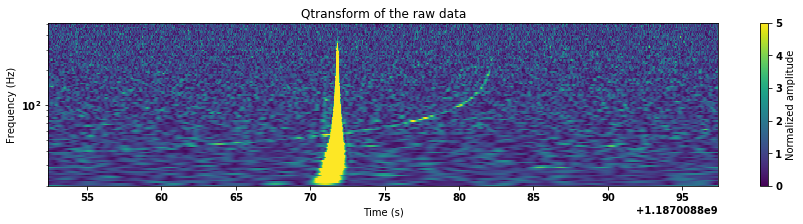

In [47]:
#qtransformm of the data
white_sig10 = (sigF10/psdA10**0.5).to_timeseries()
zoom = white_sig10.time_slice(merger.time - 30, merger.time + 15)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time + 15)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [48]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA10 = None
maxsnrA10, m1maxA10, m2maxA10, tmaxA10 = 0, 0, 0, 0

snrsA10 = [[] for i in range(len(mass1))]
max_snrsA10 = [[] for i in range(len(mass1))]
times_maxA10 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF10.delta_f)
        hp.resize(len(sigF10))
        
        #do the max filtering
        snr = matched_filter(hp, sigF10, psd = psdA10, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA10[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA10[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA10[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA10:
            tmaxA10, hmaxA10, m1maxA10, m2maxA10, maxsnrA10 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA10, m2maxA10, tmaxA10, maxsnrA10))
print(merger.time)
print(timeBH10)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 25.2837951
1187008882.4
1187008871.8455567


(1187008852.4, 1187008884.4)

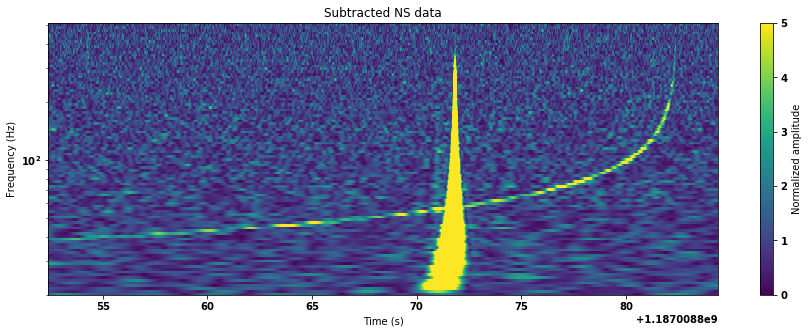

In [51]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA10 - sigF10.start_time
inj = hmaxA10.cyclic_time_shift(dt)

inj/= sigma(hmaxA10, psd = psdA10, low_frequency_cutoff = 20.)
inj *= maxsnrA10

subF10 = sigF10 - inj

subT_w10 = (subF10/psdA10**0.5).to_timeseries()
zoom = subT_w10.time_slice(merger.time - 30, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)

In [53]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB10 = None
maxsnrB10, m1maxB10, m2maxB10, tmaxB10 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF10.delta_f)
        hp.resize(len(sigF10))
        
        snr = matched_filter(hp, sigF10, psd = psdA10, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB10:
            tmaxB10, hmaxB10, m1maxB10, m2maxB10, maxsnrB10 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB10, m2maxB10, tmaxB10, maxsnrB10))
print(timeBH10)

mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 30.00, m2 = 30.10 at time 1187008871.8514161 with a value 183.7996220
1187008871.8455567


The 10 seconds gap work, we can retrieve the two events with coherant parameters

## For a 5 s time gap
Now, we test for the BH 5 second prior to the NS merger

In [54]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [59]:

time_shifts = np.arange(200, 300, 0.2)

modelBH5 = None
maxAmpBH5, timeBH5, time_dif5 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - maxAmpT
    #print(timeDif)
    #print(abs(timeDif - 110))
    if (timeDif < -4.5) and (timeDif > -5.5) :
        print("in loop")
        modelBH5 = hpInj
        maxAmpBH5, timeBH5, time_dif5 = max_amp, time_inj, timeDif

in loop
in loop
in loop
in loop
in loop


In [60]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH5)
print("The time of this maximum is: ", timeBH5)
print("The time of the meger is: ", merger.time-1)
print("The time difference is: ", time_dif5)

('The maximum amplitude of the injection is: ', 6.893045907737768e-21)
('The time of this maximum is: ', 1187008876.8455567)
('The time of the meger is: ', 1187008881.4)
('The time difference is: ', -4.533203125)


In [61]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH5.sample_times, modelBH5, label = 'injection')
plt.axvline(maxAmpT, color = 'red', alpha = 0.5)


In [62]:
#addition of the two signals

sig5 = strainL1 + modelBH5

sigF5 = sig5.to_frequencyseries()

In [63]:
#psd of the added signal

pA5 = sig5.psd(2)
pA5 = interpolate(pA5, sig5.delta_f)
psdA5 = inverse_spectrum_truncation(pA5, 2*sig5.sample_rate,
                                  low_frequency_cutoff = 20.)

Text(0,0.5,'Normalized amplitude')

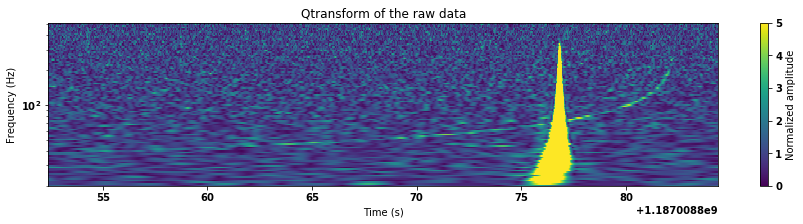

In [64]:
#qtransformm of the data
white_sig5 = (sigF5/psdA5**0.5).to_timeseries()
zoom = white_sig5.time_slice(merger.time - 30, merger.time + 2)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [65]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA5 = None
maxsnrA5, m1maxA5, m2maxA5, tmaxA5 = 0, 0, 0, 0

snrsA5 = [[] for i in range(len(mass1))]
max_snrsA5 = [[] for i in range(len(mass1))]
times_maxA5 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF5.delta_f)
        hp.resize(len(sigF5))
        
        #do the max filtering
        snr = matched_filter(hp, sigF5, psd = psdA5, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA5[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA5[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA5[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA5:
            tmaxA5, hmaxA5, m1maxA5, m2maxA5, maxsnrA5 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA5, m2maxA5, tmaxA5, maxsnrA5))
print(merger.time)
print(timeBH5)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 24.0633617
1187008882.4
1187008876.8455567


(1187008852.4, 1187008884.4)

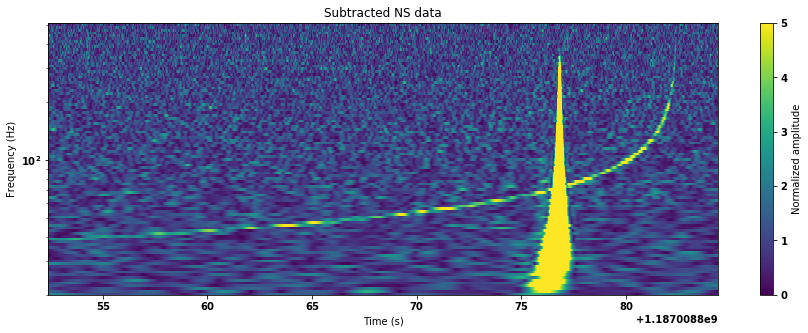

In [67]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA5 - sigF5.start_time
inj = hmaxA5.cyclic_time_shift(dt)

inj/= sigma(hmaxA5, psd = psdA5, low_frequency_cutoff = 20.)
inj *= maxsnrA5

subF5 = sigF5 - inj

subT_w5 = (subF5/psdA5**0.5).to_timeseries()
zoom = subT_w5.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)

In [68]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB5 = None
maxsnrB5, m1maxB5, m2maxB5, tmaxB5 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF5.delta_f)
        hp.resize(len(sigF5))
        
        snr = matched_filter(hp, sigF5, psd = psdA5, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB5:
            tmaxB5, hmaxB5, m1maxB5, m2maxB5, maxsnrB5 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB5, m2maxB5, tmaxB5, maxsnrB5))
print(timeBH5)

mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 30.10, m2 = 30.10 at time 1187008876.8514161 with a value 182.5667434
1187008876.8455567


The parameters that are found are still the same and coherant with the injection and the event

## For 2.5 s

In [6]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']


In [7]:
time_shifts = np.arange(200, 300, 0.2)

modelBH2 = None
maxAmpBH2, timeBH2, time_dif2 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - maxAmpT
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < -2.2) and (timeDif > -2.7) :
        print("in loop")
        modelBH2 = hpInj
        maxAmpBH2, timeBH2, time_dif2 = max_amp, time_inj, timeDif

in loop
in loop


In [8]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH2)
print("The time of this maximum is: ", timeBH2)
print("The time of the meger is: ", merger.time-1)
print("The time difference is: ", time_dif2)

('The maximum amplitude of the injection is: ', 6.862588673158071e-21)
('The time of this maximum is: ', 1187008879.045508)
('The time of the meger is: ', 1187008881.4)
('The time difference is: ', -2.333251953125)


/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


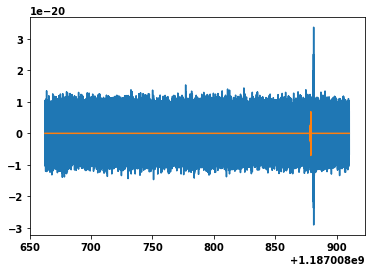

In [9]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH2.sample_times, modelBH2, label = 'injection')

In [10]:
#addition of the two signals

sig2 = strainL1 + modelBH2

sigF2 = sig2.to_frequencyseries()

In [11]:
#psd of the added signal

pA2 = sig2.psd(2)
pA2 = interpolate(pA2, sig2.delta_f)
psdA2 = inverse_spectrum_truncation(pA2, 2*sig2.sample_rate,
                                  low_frequency_cutoff = 20.)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

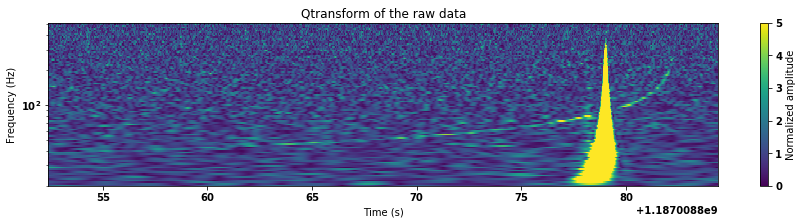

In [12]:
#qtransform of the data
white_sig2 = (sigF2/psdA2**0.5).to_timeseries()
zoom = white_sig2.time_slice(merger.time - 30, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [13]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA2 = None
maxsnrA2, m1maxA2, m2maxA2, tmaxA2 = 0, 0, 0, 0

snrsA2 = [[] for i in range(len(mass1))]
max_snrsA2 = [[] for i in range(len(mass1))]
times_maxA2 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF2.delta_f)
        hp.resize(len(sigF2))
        
        #do the max filtering
        snr = matched_filter(hp, sigF2, psd = psdA2, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA2[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA2[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA2[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA2:
            tmaxA2, hmaxA2, m1maxA2, m2maxA2, maxsnrA2 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA2, m2maxA2, tmaxA2, maxsnrA2))
print(merger.time)
print(timeBH2)


Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 26.2051791
1187008882.4
1187008879.045508


(1187008852.4, 1187008884.4)

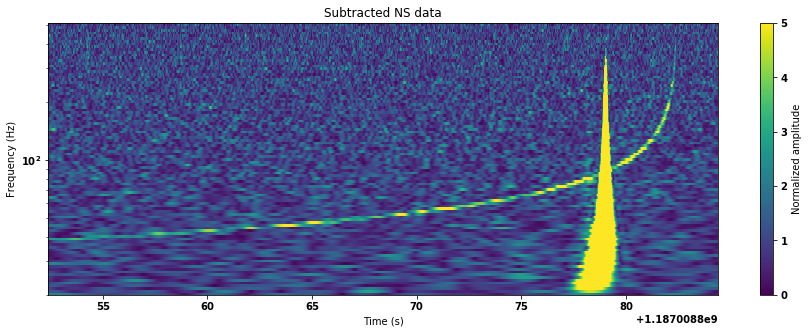

In [15]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA2 - sigF2.start_time
inj = hmaxA2.cyclic_time_shift(dt)

inj/= sigma(hmaxA2, psd = psdA2, low_frequency_cutoff = 20.)
inj *= maxsnrA2

subF2 = sigF2 - inj

subT_w2 = (subF2/psdA2**0.5).to_timeseries()
zoom = subT_w2.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)


In [17]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB2 = None
maxsnrB2, m1maxB2, m2maxB2, tmaxB2 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF2.delta_f)
        hp.resize(len(sigF2))
        
        snr = matched_filter(hp, sigF2, psd = psdA2, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB2:
            tmaxB2, hmaxB2, m1maxB2, m2maxB2, maxsnrB2 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB2, m2maxB2, tmaxB2, maxsnrB2))
print(timeBH2)


mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 30.10, m2 = 30.10 at time 1187008879.0513673 with a value 182.4434322
1187008879.045508


We see that for this time gap, the technique still works

## For 1s 

In [18]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [20]:
time_shifts = np.arange(200, 300, 0.2)

modelBH1 = None
maxAmpBH1, timeBH1, time_dif1 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - maxAmpT
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < -0.7) and (timeDif > -1.2) :
        print("in loop")
        modelBH1 = hpInj
        maxAmpBH1, timeBH1, time_dif1 = max_amp, time_inj, timeDif

in loop
in loop
in loop


In [21]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH1)
print("The time of this maximum is: ", timeBH1)
print("The time of the meger is: ", merger.time-1)
print("The time difference is: ", time_dif1)

('The maximum amplitude of the injection is: ', 6.907000737169183e-21)
('The time of this maximum is: ', 1187008880.6456056)
('The time of the meger is: ', 1187008881.4)
('The time difference is: ', -0.733154296875)


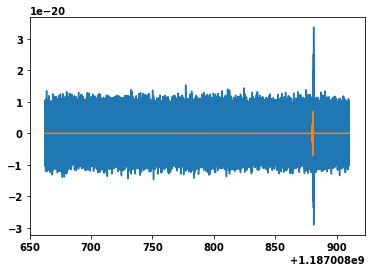

In [22]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH1.sample_times, modelBH1, label = 'injection')

In [23]:
#addition of the two signals

sig1= strainL1 + modelBH1

sigF1 = sig1.to_frequencyseries()

In [26]:
pA1= sig1.psd(2)
pA1 = interpolate(pA1, sig1.delta_f)
psdA1 = inverse_spectrum_truncation(pA1, 2*sig1.sample_rate,
                                  low_frequency_cutoff = 20.)

Text(0,0.5,'Normalized amplitude')

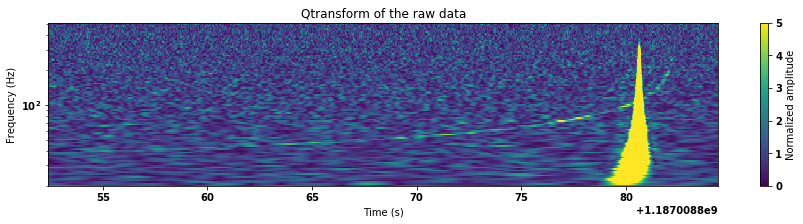

In [27]:
#qtransform of the data
white_sig1 = (sigF1/psdA1**0.5).to_timeseries()
zoom = white_sig1.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")


In [28]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA1 = None
maxsnrA1, m1maxA1, m2maxA1, tmaxA1 = 0, 0, 0, 0

snrsA1 = [[] for i in range(len(mass1))]
max_snrsA1 = [[] for i in range(len(mass1))]
times_maxA1 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF1.delta_f)
        hp.resize(len(sigF1))
        
        #do the max filtering
        snr = matched_filter(hp, sigF1, psd = psdA1, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA1[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA1[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA1[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA1:
            tmaxA1, hmaxA1, m1maxA1, m2maxA1, maxsnrA1 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA1, m2maxA1, tmaxA1, maxsnrA1))
print(merger.time)
print(timeBH1)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 24.2812990
1187008882.4
1187008880.6456056


(1187008852.4, 1187008884.4)

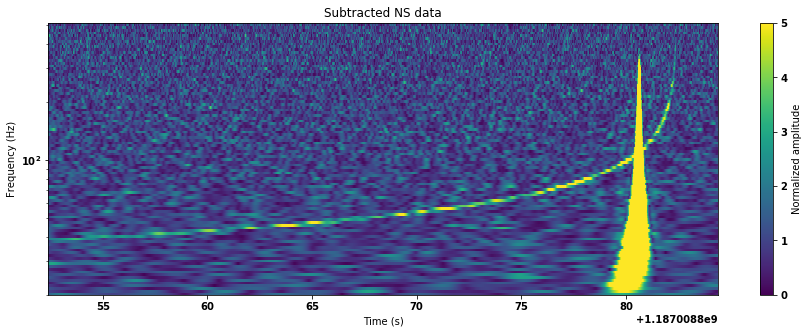

In [29]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA1 - sigF1.start_time
inj = hmaxA1.cyclic_time_shift(dt)

inj/= sigma(hmaxA1, psd = psdA1, low_frequency_cutoff = 20.)
inj *= maxsnrA1

subF1 = sigF1 - inj

subT_w1 = (subF1/psdA1**0.5).to_timeseries()
zoom = subT_w1.time_slice(merger.time - 30, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)

In [30]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB1 = None
maxsnrB1, m1maxB1, m2maxB1, tmaxB1 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF1.delta_f)
        hp.resize(len(sigF1))
        
        snr = matched_filter(hp, sigF1, psd = psdA1, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB1:
            tmaxB1, hmaxB1, m1maxB1, m2maxB1, maxsnrB1 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB1, m2maxB1, tmaxB1, maxsnrB1))
print(timeBH1)


mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 28.50, m2 = 31.90 at time 1187008880.6512208 with a value 180.4513055
1187008880.6456056


The two events are correctly found back

## For 0.5s

In [31]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [45]:
time_shifts = np.arange(200, 260, 0.1)

modelBH05 = None
maxAmpBH05, timeBH05, time_dif05 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - maxAmpT
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < -0.4) and (timeDif > -0.6) :
        print("in loop")
        modelBH05 = hpInj
        maxAmpBH05, timeBH05, time_dif05 = max_amp, time_inj, timeDif

in loop
in loop


In [46]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH05)
print("The time of this maximum is: ", timeBH05)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif05)

('The maximum amplitude of the injection is: ', 6.90413927548761e-21)
('The time of this maximum is: ', 1187008880.9456544)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -0.43310546875)


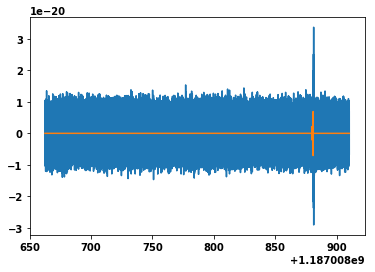

In [47]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH05.sample_times, modelBH05, label = 'injection')

In [48]:
#addition of the two signals

sig05 = strainL1 + modelBH05

sigF05 = sig05.to_frequencyseries()

In [49]:
#psd of the added signal

pA05 = sig05.psd(2)
pA05 = interpolate(pA05, sig05.delta_f)
psdA05 = inverse_spectrum_truncation(pA05, 2*sig05.sample_rate,
                                  low_frequency_cutoff = 20.)

Text(0,0.5,'Normalized amplitude')

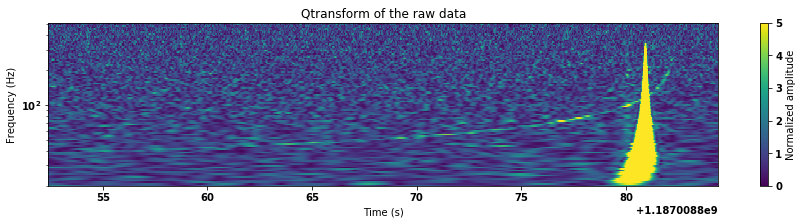

In [50]:
#qtransform of the data
white_sig05 = (sigF05/psdA05**0.5).to_timeseries()
zoom = white_sig05.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [51]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA05 = None
maxsnrA05, m1maxA05, m2maxA05, tmaxA05 = 0, 0, 0, 0

snrsA05 = [[] for i in range(len(mass1))]
max_snrsA05 = [[] for i in range(len(mass1))]
times_maxA05 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF05.delta_f)
        hp.resize(len(sigF05))
        
        #do the max filtering
        snr = matched_filter(hp, sigF05, psd = psdA05, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA05[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA05[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA05[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA05:
            tmaxA05, hmaxA05, m1maxA05, m2maxA05, maxsnrA05 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA05, m2maxA05, tmaxA05, maxsnrA05))
print(merger.time)
print(timeBH05)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 21.0627049
1187008882.4
1187008880.9456544


(1187008852.4, 1187008884.4)

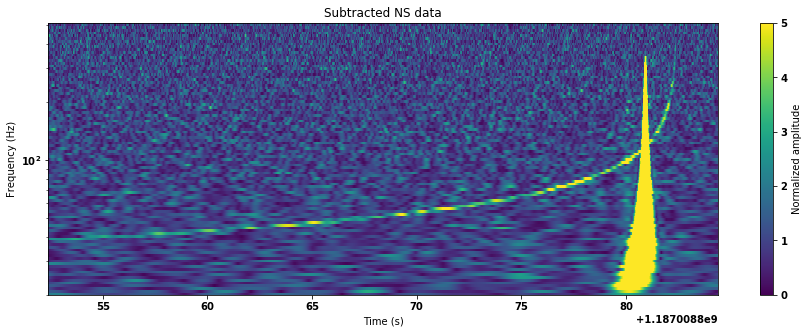

In [52]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA05 - sigF05.start_time
inj = hmaxA05.cyclic_time_shift(dt)

inj/= sigma(hmaxA05, psd = psdA05, low_frequency_cutoff = 20.)
inj *= maxsnrA05

subF05 = sigF05 - inj

subT_w05 = (subF05/psdA05**0.5).to_timeseries()
zoom = subT_w05.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)

In [53]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB05 = None
maxsnrB05, m1maxB05, m2maxB05, tmaxB05 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF05.delta_f)
        hp.resize(len(sigF05))
        
        snr = matched_filter(hp, sigF05, psd = psdA05, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB05:
            tmaxB05, hmaxB05, m1maxB05, m2maxB05, maxsnrB05 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB05, m2maxB05, tmaxB05, maxsnrB05))
print(timeBH05)



mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 28.50, m2 = 31.90 at time 1187008880.9512696 with a value 180.3102183
1187008880.9456544


We see that the two events are still well foud even if the parameters of the black hole are slightly changed. It could be that the parameters found would be better if we wera able to subtract the neutron stars out of the data before

## For 0.1s

In [5]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [6]:
time_shifts = np.arange(215, 220, 0.01)

modelBH01 = None
maxAmpBH01, timeBH01, time_dif01 = 0, 0, 0
for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - maxAmpT
    #print(t, abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < -0.08) and (timeDif > -0.12) :
        print("in loop")
        modelBH01 = hpInj
        maxAmpBH01, timeBH01, time_dif01 = max_amp, time_inj, timeDif

in loop
in loop
in loop
in loop


In [7]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH01)
print("The time of this maximum is: ", timeBH01)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif01)


('The maximum amplitude of the injection is: ', 6.86258867464089e-21)
('The time of this maximum is: ', 1187008881.295508)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -0.083251953125)


/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


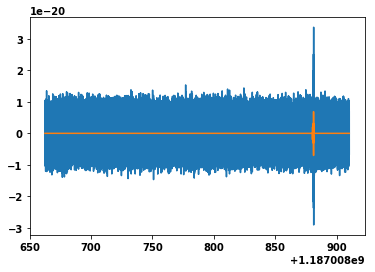

In [8]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH01.sample_times, modelBH01, label = 'injection')

In [9]:
#addition of the two signals

sig01 = strainL1 + modelBH01

sigF01 = sig01.to_frequencyseries()

In [10]:
#psd of the added signal

pA01 = sig01.psd(2)
pA01 = interpolate(pA01, sig01.delta_f)
psdA01 = inverse_spectrum_truncation(pA01, 2*sig01.sample_rate,
                                  low_frequency_cutoff = 20.)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

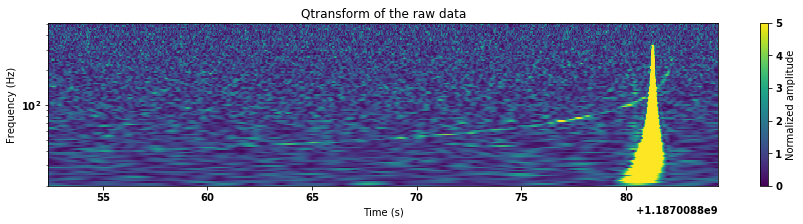

In [11]:
#qtransform of the data
white_sig01 = (sigF01/psdA01**0.5).to_timeseries()
zoom = white_sig01.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [12]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA01 = None
maxsnrA01, m1maxA01, m2maxA01, tmaxA01 = 0, 0, 0, 0

snrsA01 = [[] for i in range(len(mass1))]
max_snrsA01 = [[] for i in range(len(mass1))]
times_maxA01 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF01.delta_f)
        hp.resize(len(sigF01))
        
        #do the max filtering
        snr = matched_filter(hp, sigF01, psd = psdA01, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA01[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA01[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA01[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA01:
            tmaxA01, hmaxA01, m1maxA01, m2maxA01, maxsnrA01 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA01, m2maxA01, tmaxA01, maxsnrA01))
print(merger.time)
print(timeBH01)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 25.5428572
1187008882.4
1187008881.295508


(1187008852.4, 1187008884.4)

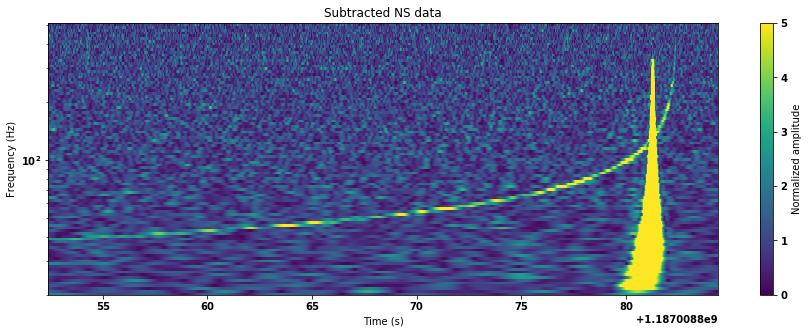

In [13]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA01 - sigF01.start_time
inj = hmaxA01.cyclic_time_shift(dt)

inj/= sigma(hmaxA01, psd = psdA01, low_frequency_cutoff = 20.)
inj *= maxsnrA01

subF01 = sigF01 - inj

subT_w01 = (subF01/psdA01**0.5).to_timeseries()
zoom = subT_w01.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)

In [14]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB01 = None
maxsnrB01, m1maxB01, m2maxB01, tmaxB01 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF01.delta_f)
        hp.resize(len(sigF01))
        
        snr = matched_filter(hp, sigF01, psd = psdA01, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB01:
            tmaxB01, hmaxB01, m1maxB01, m2maxB01, maxsnrB01 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB01, m2maxB01, tmaxB01, maxsnrB01))
print(timeBH01)


mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 28.40, m2 = 31.90 at time 1187008881.3013673 with a value 182.7778111
1187008881.295508


same as for 0.5s

## For 0.05 s

In [15]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [16]:
time_shifts = np.arange(215, 220, 0.01)

modelBH005 = None
maxAmpBH005, timeBH005, time_dif005 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - maxAmpT
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < -.04) and (timeDif > -0.06) :
        print("in loop")
        modelBH005 = hpInj
        maxAmpBH005, timeBH005, time_dif005 = max_amp, time_inj, timeDif

in loop
in loop


In [17]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH005)
print("The time of this maximum is: ", timeBH005)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif005)


('The maximum amplitude of the injection is: ', 6.888263703624974e-21)
('The time of this maximum is: ', 1187008881.335547)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -0.043212890625)


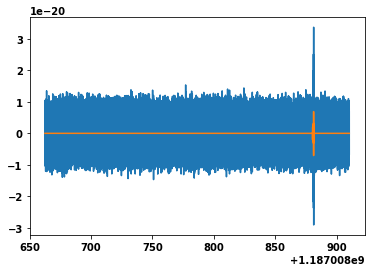

In [18]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH005.sample_times, modelBH005, label = 'injection')

In [19]:
#addition of the two signals

sig005 = strainL1 + modelBH005

sigF005 = sig005.to_frequencyseries()

In [20]:
#psd of the added signal

pA005 = sig005.psd(2)
pA005 = interpolate(pA005, sig005.delta_f)
psdA005 = inverse_spectrum_truncation(pA005, 2*sig005.sample_rate,
                                  low_frequency_cutoff = 20.)


Text(0,0.5,'Normalized amplitude')

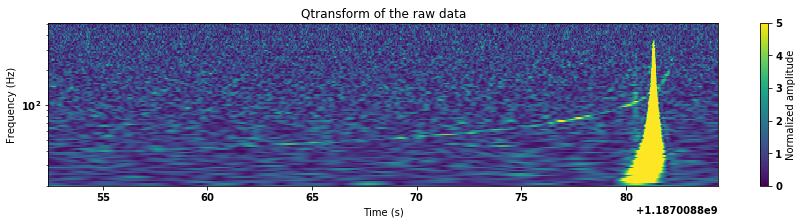

In [21]:
#qtransform of the data
white_sig005 = (sigF005/psdA005**0.5).to_timeseries()
zoom = white_sig005.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")


In [22]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA005 = None
maxsnrA005, m1maxA005, m2maxA005, tmaxA005 = 0, 0, 0, 0

snrsA005 = [[] for i in range(len(mass1))]
max_snrsA005 = [[] for i in range(len(mass1))]
times_maxA005 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF005.delta_f)
        hp.resize(len(sigF005))
        
        #do the max filtering
        snr = matched_filter(hp, sigF005, psd = psdA005, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA005[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA005[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA005[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA005:
            tmaxA005, hmaxA005, m1maxA005, m2maxA005, maxsnrA005 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA005, m2maxA005, tmaxA005, maxsnrA005))
print(merger.time)
print(timeBH005)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.0626888
1187008882.4
1187008881.335547


(1187008852.4, 1187008884.4)

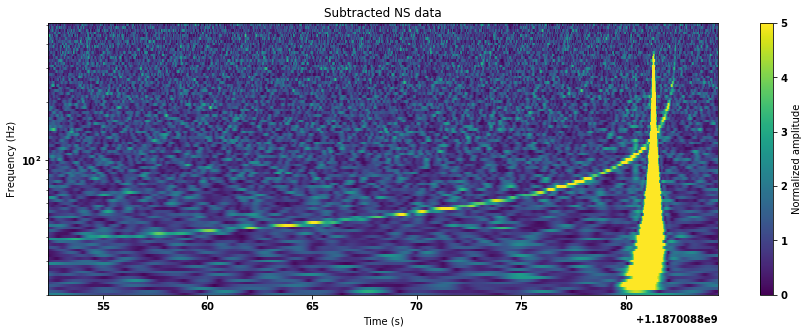

In [23]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA005 - sigF005.start_time
inj = hmaxA005.cyclic_time_shift(dt)

inj/= sigma(hmaxA005, psd = psdA005, low_frequency_cutoff = 20.)
inj *= maxsnrA005

subF005 = sigF005 - inj

subT_w005 = (subF005/psdA005**0.5).to_timeseries()
zoom = subT_w005.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)

In [24]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB005 = None
maxsnrB005, m1maxB005, m2maxB005, tmaxB005 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF005.delta_f)
        hp.resize(len(sigF005))
        
        snr = matched_filter(hp, sigF005, psd = psdA005, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB005:
            tmaxB005, hmaxB005, m1maxB005, m2maxB005, maxsnrB005 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB005, m2maxB005, tmaxB005, maxsnrB005))
print(timeBH005)

mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 30.10, m2 = 30.10 at time 1187008881.3414063 with a value 183.1432698
1187008881.335547


The subtraction is still well done for this case

## For 0.02 s
Note: this was the limit where it did not worked for two black holes anymore

In [5]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']


In [6]:
time_shifts = np.arange(215, 220, 0.01)

modelBH002 = None
maxAmpBH002, timeBH002, time_dif002 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - maxAmpT
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < -0.015) and (timeDif > -0.03) :
        print("in loop")
        modelBH002 = hpInj
        maxAmpBH002, timeBH002, time_dif002 = max_amp, time_inj, timeDif

in loop


In [7]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH002)
print("The time of this maximum is: ", timeBH002)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif002)

('The maximum amplitude of the injection is: ', 6.897167856319916e-21)
('The time of this maximum is: ', 1187008881.3555665)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -0.023193359375)


/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


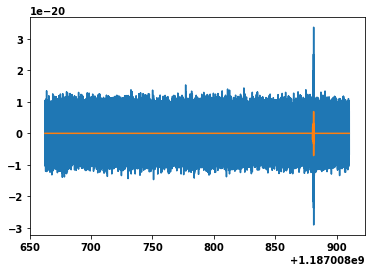

In [8]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH002.sample_times, modelBH002, label = 'injection')

In [9]:
#addition of the two signals

sig002 = strainL1 + modelBH002

sigF002 = sig002.to_frequencyseries()


In [10]:
#psd of the added signal

pA002 = sig002.psd(2)
pA002 = interpolate(pA002, sig002.delta_f)
psdA002 = inverse_spectrum_truncation(pA002, 2*sig002.sample_rate,
                                  low_frequency_cutoff = 20.)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

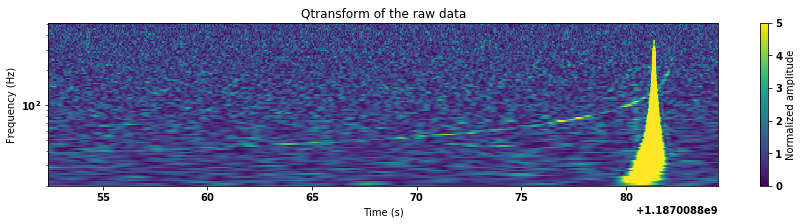

In [11]:
#qtransform of the data
white_sig002 = (sigF002/psdA002**0.5).to_timeseries()
zoom = white_sig002.time_slice(merger.time - 30, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")


In [12]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA002 = None
maxsnrA002, m1maxA002, m2maxA002, tmaxA002 = 0, 0, 0, 0

snrsA002 = [[] for i in range(len(mass1))]
max_snrsA002 = [[] for i in range(len(mass1))]
times_maxA002 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF002.delta_f)
        hp.resize(len(sigF002))
        
        #do the max filtering
        snr = matched_filter(hp, sigF002, psd = psdA002, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA002[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA002[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA002[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA002:
            tmaxA002, hmaxA002, m1maxA002, m2maxA002, maxsnrA002 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA002, m2maxA002, tmaxA002, maxsnrA002))
print(merger.time)
print(timeBH002)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 26.3065798
1187008882.4
1187008881.3555665


(1187008852.4, 1187008884.4)

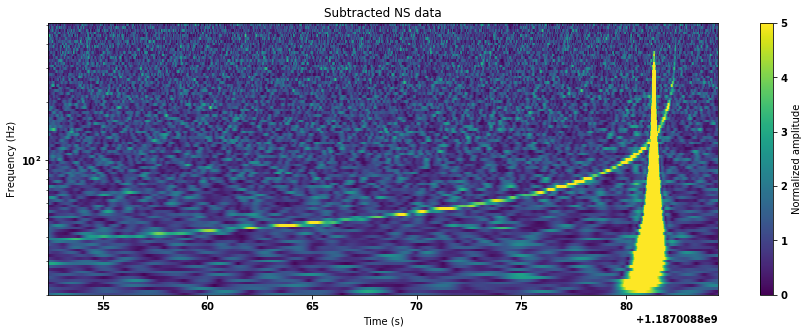

In [13]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA002 - sigF002.start_time
inj = hmaxA002.cyclic_time_shift(dt)

inj/= sigma(hmaxA002, psd = psdA002, low_frequency_cutoff = 20.)
inj *= maxsnrA002

subF002 = sigF002 - inj

subT_w002 = (subF002/psdA002**0.5).to_timeseries()
zoom = subT_w002.time_slice(merger.time - 30, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)

In [14]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB002 = None
maxsnrB002, m1maxB002, m2maxB002, tmaxB002 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF002.delta_f)
        hp.resize(len(sigF002))
        
        snr = matched_filter(hp, sigF002, psd = psdA002, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB002:
            tmaxB002, hmaxB002, m1maxB002, m2maxB002, maxsnrB002 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB002, m2maxB002, tmaxB002, maxsnrB002))
print(timeBH002)

mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 30.00, m2 = 30.10 at time 1187008881.3614259 with a value 181.8704493
1187008881.3555665


We see that the signal is still well subtracted, even if it was the time for which it did not worked well anymore for the black holes

## For 0.01

In [5]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [16]:
time_shifts = np.arange(215, 220, 0.01)

modelBH001 = None
maxAmpBH001, timeBH001, time_dif001 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < -0.005) and (timeDif > -0.015) :
        print("in loop")
        modelBH001 = hpInj
        maxAmpBH001, timeBH001, time_dif001 = max_amp, time_inj, timeDif


in loop


In [17]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH001)
print("The time of this maximum is: ", timeBH001)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif001)


('The maximum amplitude of the injection is: ', 6.905545779268166e-21)
('The time of this maximum is: ', 1187008882.3855958)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -0.014404296875)


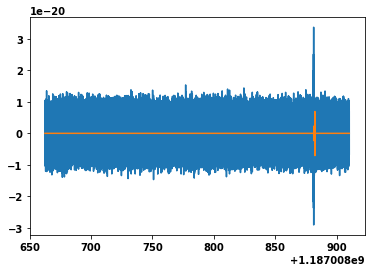

In [18]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH001.sample_times, modelBH001, label = 'injection')

In [19]:
#addition of the two signals

sig001 = strainL1 + modelBH001

sigF001 = sig001.to_frequencyseries()

In [20]:
#psd of the added signal

pA001 = sig001.psd(2)
pA001 = interpolate(pA001, sig001.delta_f)
psdA001 = inverse_spectrum_truncation(pA001, 2*sig001.sample_rate,
                                  low_frequency_cutoff = 20.)

Text(0,0.5,'Normalized amplitude')

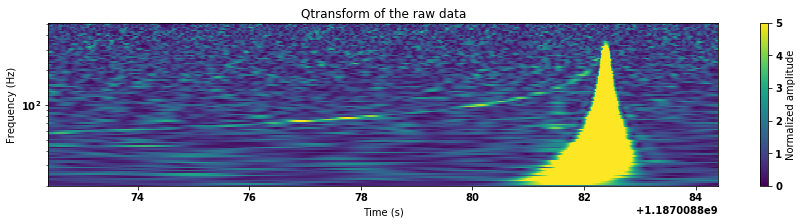

In [21]:
#qtransform of the data
white_sig001 = (sigF001/psdA001**0.5).to_timeseries()
zoom = white_sig001.time_slice(merger.time - 30, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 10, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [22]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA001 = None
maxsnrA001, m1maxA001, m2maxA001, tmaxA001 = 0, 0, 0, 0

snrsA001 = [[] for i in range(len(mass1))]
max_snrsA001 = [[] for i in range(len(mass1))]
times_maxA001 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF001.delta_f)
        hp.resize(len(sigF001))
        
        #do the max filtering
        snr = matched_filter(hp, sigF001, psd = psdA001, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA001[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA001[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA001[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA001:
            tmaxA001, hmaxA001, m1maxA001, m2maxA001, maxsnrA001 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA001, m2maxA001, tmaxA001, maxsnrA001))
print(merger.time)
print(timeBH001)


Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 24.0371428
1187008882.4
1187008882.3855958


(1187008872.4, 1187008884.4)

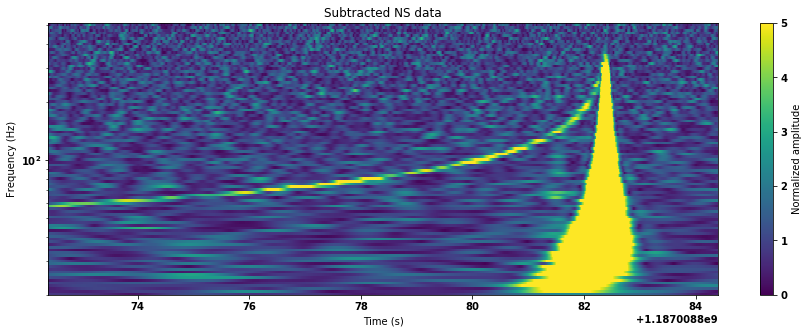

In [23]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA001 - sigF001.start_time
inj = hmaxA001.cyclic_time_shift(dt)

inj/= sigma(hmaxA001, psd = psdA001, low_frequency_cutoff = 20.)
inj *= maxsnrA001

subF001 = sigF001 - inj

subT_w001 = (subF001/psdA001**0.5).to_timeseries()
zoom = subT_w001.time_slice(merger.time - 30, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 10, merger.time +2)

In [24]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB001 = None
maxsnrB001, m1maxB001, m2maxB001, tmaxB001 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF001.delta_f)
        hp.resize(len(sigF001))
        
        snr = matched_filter(hp, sigF001, psd = psdA001, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB001:
            tmaxB001, hmaxB001, m1maxB001, m2maxB001, maxsnrB001 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB001, m2maxB001, tmaxB001, maxsnrB001))
print(timeBH001)

mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 28.50, m2 = 31.90 at time 1187008882.3912110 with a value 182.1193691
1187008882.3855958


The signal is well subtracted in this case as well

## For 0.005s
Here, the time gap is very small, needing to increase the precision of the loop as well as decrease the range over which we loop in order to see if it is possible to find such a precision

In [17]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [18]:
time_shifts = np.arange(215, 220, 0.001)

modelBH0005 = None
maxAmpBH0005, timeBH0005, time_dif0005 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < -0.0025) and (timeDif > -0.0075) :
        print("in loop")
        modelBH0005 = hpInj
        maxAmpBH0005, timeBH0005, time_dif0005 = max_amp, time_inj, timeDif

in loop
in loop
in loop
in loop
in loop


In [24]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH0005)
print("The time of this maximum is: ", timeBH0005)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_dif0005)


('The maximum amplitude of the injection is: ', 6.902382975145583e-21)
('The time of this maximum is: ', 1187008882.3965821)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', -0.00341796875)


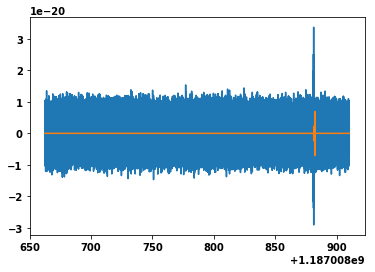

In [25]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH0005.sample_times, modelBH0005, label = 'injection')

In [26]:
#addition of the two signals

sig0005 = strainL1 + modelBH0005

sigF0005 = sig0005.to_frequencyseries()


In [27]:
#psd of the added signal

pA0005 = sig0005.psd(2)
pA0005 = interpolate(pA0005, sig0005.delta_f)
psdA0005 = inverse_spectrum_truncation(pA0005, 2*sig0005.sample_rate,
                                  low_frequency_cutoff = 20.)


Text(0,0.5,'Normalized amplitude')

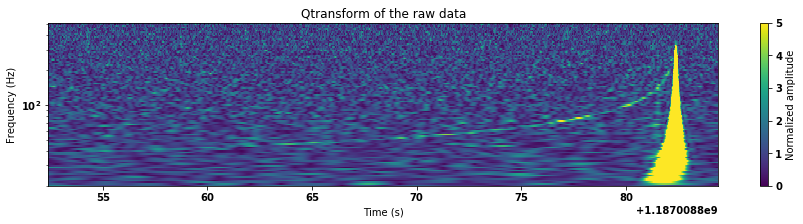

In [23]:
#qtransform of the data
white_sig0005 = (sigF0005/psdA0005**0.5).to_timeseries()
zoom = white_sig0005.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [28]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA0005 = None
maxsnrA0005, m1maxA0005, m2maxA0005, tmaxA0005 = 0, 0, 0, 0

snrsA0005 = [[] for i in range(len(mass1))]
max_snrsA0005 = [[] for i in range(len(mass1))]
times_maxA0005 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF0005.delta_f)
        hp.resize(len(sigF0005))
        
        #do the max filtering
        snr = matched_filter(hp, sigF0005, psd = psdA0005, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA0005[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA0005[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA0005[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA0005:
            tmaxA0005, hmaxA0005, m1maxA0005, m2maxA0005, maxsnrA0005 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA0005, m2maxA0005, tmaxA0005, maxsnrA0005))
print(merger.time)
print(timeBH0005)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.7777815
1187008882.4
1187008882.3965821


(1187008852.4, 1187008884.4)

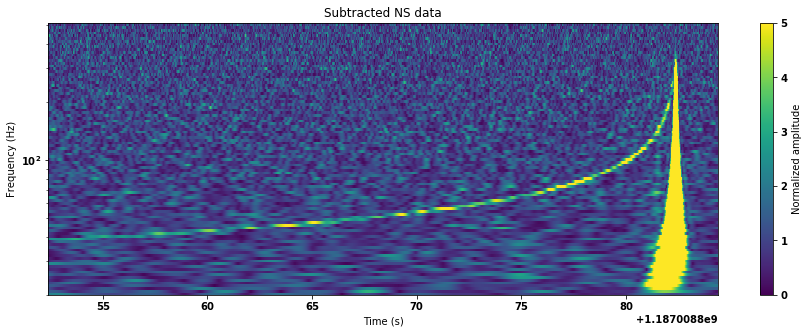

In [30]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA0005 - sigF0005.start_time
inj = hmaxA0005.cyclic_time_shift(dt)

inj/= sigma(hmaxA0005, psd = psdA0005, low_frequency_cutoff = 20.)
inj *= maxsnrA0005

subF0005 = sigF0005 - inj

subT_w0005 = (subF0005/psdA0005**0.5).to_timeseries()
zoom = subT_w0005.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)

In [31]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB0005 = None
maxsnrB0005, m1maxB0005, m2maxB0005, tmaxB0005 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF0005.delta_f)
        hp.resize(len(sigF0005))
        
        snr = matched_filter(hp, sigF0005, psd = psdA0005, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB0005:
            tmaxB0005, hmaxB0005, m1maxB0005, m2maxB0005, maxsnrB0005 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB0005, m2maxB0005, tmaxB0005, maxsnrB0005))
print(timeBH0005)

mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 30.00, m2 = 30.10 at time 1187008882.4024415 with a value 183.9692543
1187008882.3965821


works

## For 0s

In [32]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [39]:
time_shifts = np.arange(218, 222, 0.001)

modelBH0 = None
maxAmpBH0, timeBH0, time_dif0 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - merger.time
    print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < 0.002) and (timeDif > -0.002) :
        print("in loop")
        modelBH0 = hpInj
        maxAmpBH0, timeBH0, time_dif0 = max_amp, time_inj, timeDif

1.154296875
1.1533203125
1.15234375
1.1513671875
1.150390625
1.1494140625
1.1484375
1.1474609375
1.146484375
1.145263671875
1.144287109375
1.143310546875
1.142333984375
1.141357421875
1.140380859375
1.139404296875
1.138427734375
1.137451171875
1.136474609375
1.135498046875
1.13427734375
1.13330078125
1.13232421875
1.13134765625
1.13037109375
1.12939453125
1.12841796875
1.12744140625
1.12646484375
1.12548828125
1.124267578125
1.123291015625
1.122314453125
1.121337890625
1.120361328125
1.119384765625
1.118408203125
1.117431640625
1.116455078125
1.115478515625
1.1142578125
1.11328125
1.1123046875
1.111328125
1.1103515625
1.109375
1.1083984375
1.107421875
1.1064453125
1.10546875
1.1044921875
1.103271484375
1.102294921875
1.101318359375
1.100341796875
1.099365234375
1.098388671875
1.097412109375
1.096435546875
1.095458984375
1.094482421875
1.09326171875
1.09228515625
1.09130859375
1.09033203125
1.08935546875
1.08837890625
1.08740234375
1.08642578125
1.08544921875
1.08447265625
1.08349609375

0.5673828125
0.56640625
0.5654296875
0.564453125
0.5634765625
0.5625
0.561279296875
0.560302734375
0.559326171875
0.558349609375
0.557373046875
0.556396484375
0.555419921875
0.554443359375
0.553466796875
0.552490234375
0.55126953125
0.55029296875
0.54931640625
0.54833984375
0.54736328125
0.54638671875
0.54541015625
0.54443359375
0.54345703125
0.54248046875
0.541259765625
0.540283203125
0.539306640625
0.538330078125
0.537353515625
0.536376953125
0.535400390625
0.534423828125
0.533447265625
0.532470703125
0.531494140625
0.5302734375
0.529296875
0.5283203125
0.52734375
0.5263671875
0.525390625
0.5244140625
0.5234375
0.5224609375
0.521484375
0.520263671875
0.519287109375
0.518310546875
0.517333984375
0.516357421875
0.515380859375
0.514404296875
0.513427734375
0.512451171875
0.511474609375
0.510498046875
0.50927734375
0.50830078125
0.50732421875
0.50634765625
0.50537109375
0.50439453125
0.50341796875
0.50244140625
0.50146484375
0.50048828125
0.499267578125
0.498291015625
0.497314453125
0.49

0.0166015625
0.017578125
0.0185546875
0.01953125
0.0205078125
0.021728515625
0.022705078125
0.023681640625
0.024658203125
0.025634765625
0.026611328125
0.027587890625
0.028564453125
0.029541015625
0.030517578125
0.03173828125
0.03271484375
0.03369140625
0.03466796875
0.03564453125
0.03662109375
0.03759765625
0.03857421875
0.03955078125
0.04052734375
0.04150390625
0.042724609375
0.043701171875
0.044677734375
0.045654296875
0.046630859375
0.047607421875
0.048583984375
0.049560546875
0.050537109375
0.051513671875
0.052734375
0.0537109375
0.0546875
0.0556640625
0.056640625
0.0576171875
0.05859375
0.0595703125
0.060546875
0.0615234375
0.0625
0.063720703125
0.064697265625
0.065673828125
0.066650390625
0.067626953125
0.068603515625
0.069580078125
0.070556640625
0.071533203125
0.072509765625
0.07373046875
0.07470703125
0.07568359375
0.07666015625
0.07763671875
0.07861328125
0.07958984375
0.08056640625
0.08154296875
0.08251953125
0.083740234375
0.084716796875
0.085693359375
0.086669921875
0.087

0.604736328125
0.605712890625
0.606689453125
0.607666015625
0.608642578125
0.609619140625
0.610595703125
0.611572265625
0.612548828125
0.613525390625
0.614501953125
0.61572265625
0.61669921875
0.61767578125
0.61865234375
0.61962890625
0.62060546875
0.62158203125
0.62255859375
0.62353515625
0.62451171875
0.625732421875
0.626708984375
0.627685546875
0.628662109375
0.629638671875
0.630615234375
0.631591796875
0.632568359375
0.633544921875
0.634521484375
0.6357421875
0.63671875
0.6376953125
0.638671875
0.6396484375
0.640625
0.6416015625
0.642578125
0.6435546875
0.64453125
0.6455078125
0.646728515625
0.647705078125
0.648681640625
0.649658203125
0.650634765625
0.651611328125
0.652587890625
0.653564453125
0.654541015625
0.655517578125
0.65673828125
0.65771484375
0.65869140625
0.65966796875
0.66064453125
0.66162109375
0.66259765625
0.66357421875
0.66455078125
0.66552734375
0.66650390625
0.667724609375
0.668701171875
0.669677734375
0.670654296875
0.671630859375
0.672607421875
0.673583984375
0.6

1.190673828125
1.191650390625
1.192626953125
1.193603515625
1.194580078125
1.195556640625
1.196533203125
1.197509765625
1.19873046875
1.19970703125
1.20068359375
1.20166015625
1.20263671875
1.20361328125
1.20458984375
1.20556640625
1.20654296875
1.20751953125
1.208740234375
1.209716796875
1.210693359375
1.211669921875
1.212646484375
1.213623046875
1.214599609375
1.215576171875
1.216552734375
1.217529296875
1.218505859375
1.2197265625
1.220703125
1.2216796875
1.22265625
1.2236328125
1.224609375
1.2255859375
1.2265625
1.2275390625
1.228515625
1.229736328125
1.230712890625
1.231689453125
1.232666015625
1.233642578125
1.234619140625
1.235595703125
1.236572265625
1.237548828125
1.238525390625
1.239501953125
1.24072265625
1.24169921875
1.24267578125
1.24365234375
1.24462890625
1.24560546875
1.24658203125
1.24755859375
1.24853515625
1.24951171875
1.250732421875
1.251708984375
1.252685546875
1.253662109375
1.254638671875
1.255615234375
1.256591796875
1.257568359375
1.258544921875
1.25952148437

1.776611328125
1.777587890625
1.778564453125
1.779541015625
1.780517578125
1.78173828125
1.78271484375
1.78369140625
1.78466796875
1.78564453125
1.78662109375
1.78759765625
1.78857421875
1.78955078125
1.79052734375
1.79150390625
1.792724609375
1.793701171875
1.794677734375
1.795654296875
1.796630859375
1.797607421875
1.798583984375
1.799560546875
1.800537109375
1.801513671875
1.802734375
1.8037109375
1.8046875
1.8056640625
1.806640625
1.8076171875
1.80859375
1.8095703125
1.810546875
1.8115234375
1.8125
1.813720703125
1.814697265625
1.815673828125
1.816650390625
1.817626953125
1.818603515625
1.819580078125
1.820556640625
1.821533203125
1.822509765625
1.82373046875
1.82470703125
1.82568359375
1.82666015625
1.82763671875
1.82861328125
1.82958984375
1.83056640625
1.83154296875
1.83251953125
1.833740234375
1.834716796875
1.835693359375
1.836669921875
1.837646484375
1.838623046875
1.839599609375
1.840576171875
1.841552734375
1.842529296875
1.843505859375
1.8447265625
1.845703125
1.8466796875

2.362548828125
2.363525390625
2.364501953125
2.36572265625
2.36669921875
2.36767578125
2.36865234375
2.36962890625
2.37060546875
2.37158203125
2.37255859375
2.37353515625
2.37451171875
2.375732421875
2.376708984375
2.377685546875
2.378662109375
2.379638671875
2.380615234375
2.381591796875
2.382568359375
2.383544921875
2.384521484375
2.3857421875
2.38671875
2.3876953125
2.388671875
2.3896484375
2.390625
2.3916015625
2.392578125
2.3935546875
2.39453125
2.3955078125
2.396728515625
2.397705078125
2.398681640625
2.399658203125
2.400634765625
2.401611328125
2.402587890625
2.403564453125
2.404541015625
2.405517578125
2.40673828125
2.40771484375
2.40869140625
2.40966796875
2.41064453125
2.41162109375
2.41259765625
2.41357421875
2.41455078125
2.41552734375
2.41650390625
2.417724609375
2.418701171875
2.419677734375
2.420654296875
2.421630859375
2.422607421875
2.423583984375
2.424560546875
2.425537109375
2.426513671875
2.427734375
2.4287109375
2.4296875
2.4306640625
2.431640625
2.4326171875
2.433

In [40]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBH0)
print("The time of this maximum is: ", timeBH0)
print("The time of the merger is: ", merger.time)
print("The time difference is: ", time_dif0)

('The maximum amplitude of the injection is: ', 6.880647910758499e-21)
('The time of this maximum is: ', 1187008882.401709)
('The time of the merger is: ', 1187008882.4)
('The time difference is: ', 0.001708984375)


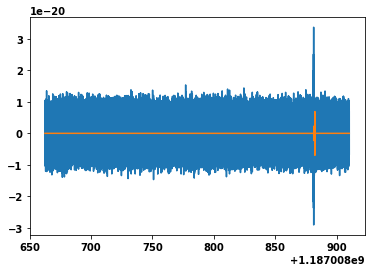

In [41]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBH0.sample_times, modelBH0, label = 'injection')

In [42]:
#addition of the two signals

sig0 = strainL1 + modelBH0

sigF0 = sig0.to_frequencyseries()

In [43]:
#psd of the added signal

pA0 = sig0.psd(2)
pA0 = interpolate(pA0, sig0.delta_f)
psdA0 = inverse_spectrum_truncation(pA0, 2*sig0.sample_rate,
                                  low_frequency_cutoff = 20.)


Text(0,0.5,'Normalized amplitude')

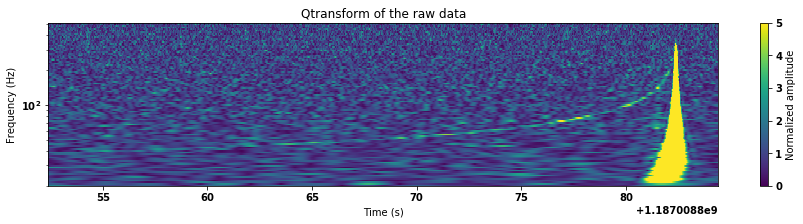

In [44]:
#qtransform of the data
white_sig0 = (sigF0/psdA0**0.5).to_timeseries()
zoom = white_sig0.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")


In [45]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxA0 = None
maxsnrA0, m1maxA0, m2maxA0, tmaxA0 = 0, 0, 0, 0

snrsA0 = [[] for i in range(len(mass1))]
max_snrsA0 = [[] for i in range(len(mass1))]
times_maxA0 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigF0.delta_f)
        hp.resize(len(sigF0))
        
        #do the max filtering
        snr = matched_filter(hp, sigF0, psd = psdA0, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsA0[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsA0[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxA0[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrA0:
            tmaxA0, hmaxA0, m1maxA0, m2maxA0, maxsnrA0 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxA0, m2maxA0, tmaxA0, maxsnrA0))
print(merger.time)
print(timeBH0)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 24.0909978
1187008882.4
1187008882.401709


(1187008852.4, 1187008884.4)

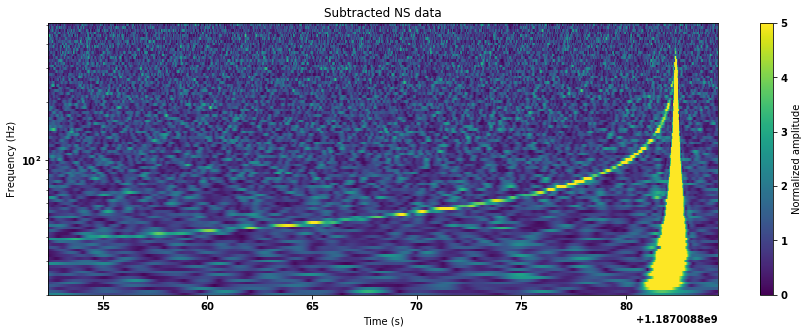

In [47]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxA0 - sigF0.start_time
inj = hmaxA0.cyclic_time_shift(dt)

inj/= sigma(hmaxA0, psd = psdA0, low_frequency_cutoff = 20.)
inj *= maxsnrA0

subF0 = sigF0 - inj

subT_w0 = (subF0/psdA0**0.5).to_timeseries()
zoom = subT_w0.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)



In [48]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxB0 = None
maxsnrB0, m1maxB0, m2maxB0, tmaxB0 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigF0.delta_f)
        hp.resize(len(sigF0))
        
        snr = matched_filter(hp, sigF0, psd = psdA0, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrB0:
            tmaxB0, hmaxB0, m1maxB0, m2maxB0, maxsnrB0 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxB0, m2maxB0, tmaxB0, maxsnrB0))
print(timeBH0)


mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 28.80, m2 = 31.50 at time 1187008882.4073243 with a value 181.2116733
1187008882.401709


The subtraction still works

## For + .005 s

Here, we look at the consequenxe to put the black hole after the NS event. Normally, it should not change anything to the NS but it could change the inspiral of the black hole and make it non-recognizable

In [5]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']


In [6]:
time_shifts = np.arange(217, 222, 0.002)

modelBHP0005 = None
maxAmpBHP0005, timeBHP0005, time_difP0005 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < 0.0075) and (timeDif > 0.0025) :
        print("in loop")
        modelBHP0005 = hpInj
        maxAmpBHP0005, timeBHP0005, time_difP0005 = max_amp, time_inj, timeDif

in loop
in loop


In [7]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBHP0005)
print("The time of this maximum is: ", timeBHP0005)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_difP0005)

('The maximum amplitude of the injection is: ', 6.907782875977688e-21)
('The time of this maximum is: ', 1187008882.4056153)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', 0.005615234375)


/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


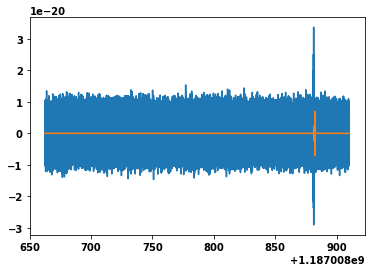

In [8]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBHP0005.sample_times, modelBHP0005, label = 'injection')

In [9]:
#addition of the two signals

sigP0005 = strainL1 + modelBHP0005

sigFP0005 = sigP0005.to_frequencyseries()

In [10]:
#psd of the added signal

pAP0005 = sigP0005.psd(2)
pAP0005 = interpolate(pAP0005, sigP0005.delta_f)
psdAP0005 = inverse_spectrum_truncation(pAP0005, 2*sigP0005.sample_rate,
                                  low_frequency_cutoff = 20.)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

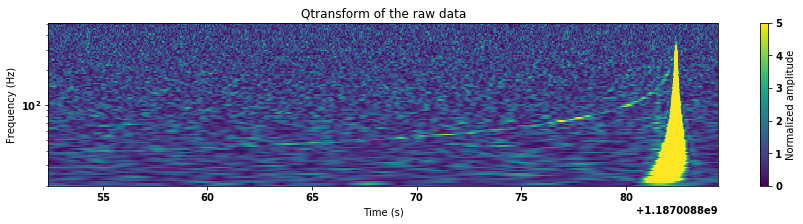

In [11]:
#qtransform of the data
white_sigP0005 = (sigFP0005/psdAP0005**0.5).to_timeseries()
zoom = white_sigP0005.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [58]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxAP0005 = None
maxsnrAP0005, m1maxAP0005, m2maxAP0005, tmaxAP0005 = 0, 0, 0, 0

snrsAP0005 = [[] for i in range(len(mass1))]
max_snrsAP0005 = [[] for i in range(len(mass1))]
times_maxAP0005 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP0005.delta_f)
        hp.resize(len(sigFP0005))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP0005, psd = psdAP0005, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsAP0005[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsAP0005[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxAP0005[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrAP0005:
            tmaxAP0005, hmaxAP0005, m1maxAP0005, m2maxAP0005, maxsnrAP0005 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxAP0005, m2maxAP0005, tmaxAP0005, maxsnrAP0005))
print(merger.time)
print(timeBHP0005)


Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.7669666
1187008882.4
1187008882.4056153


In [59]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxAP0005 - sigFP0005.start_time
inj = hmaxAP0005.cyclic_time_shift(dt)

inj/= sigma(hmaxAP0005, psd = psdAP0005, low_frequency_cutoff = 20.)
inj *= maxsnrAP0005

subFP0005 = sigFP0005 - inj

subT_wP0005 = (subFP0005/psdAP0005**0.5).to_timeseries()
zoom = subT_wP0005.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)



MemoryError: 

In [12]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxBP0005 = None
maxsnrBP0005, m1maxBP0005, m2maxBP0005, tmaxBP0005 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigFP0005.delta_f)
        hp.resize(len(sigFP0005))
        
        snr = matched_filter(hp, sigFP0005, psd = psdAP0005, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrBP0005:
            tmaxBP0005, hmaxBP0005, m1maxBP0005, m2maxBP0005, maxsnrBP0005 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxBP0005, m2maxBP0005, tmaxBP0005, maxsnrBP0005))
print(timeBHP0005)

mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 28.50, m2 = 31.90 at time 1187008882.4112306 with a value 181.8514097
1187008882.4056153


## For +0.01 s

In [13]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [20]:
time_shifts = np.arange(218, 222, 0.001)

modelBHP001 = None
maxAmpBHP001, timeBH, time_dif = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < 0.0125) and (timeDif > 0.0075) :
        print("in loop")
        modelBHP001 = hpInj
        maxAmpBHP001, timeBHP001, time_difP001 = max_amp, time_inj, timeDif

in loop
in loop
in loop
in loop
in loop


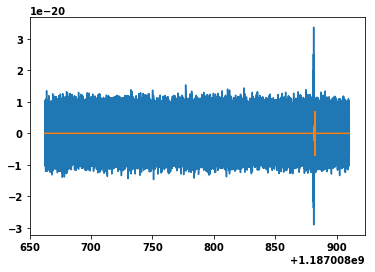

In [21]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBHP001.sample_times, modelBHP001, label = 'injection')

In [22]:
#addition of the two signals

sigP001 = strainL1 + modelBHP001

sigFP001 = sigP001.to_frequencyseries()

In [23]:
#psd of the added signal

pAP001 = sigP001.psd(2)
pAP001 = interpolate(pAP001, sigP001.delta_f)
psdAP001 = inverse_spectrum_truncation(pAP001, 2*sigP001.sample_rate,
                                  low_frequency_cutoff = 20.)

Text(0,0.5,'Normalized amplitude')

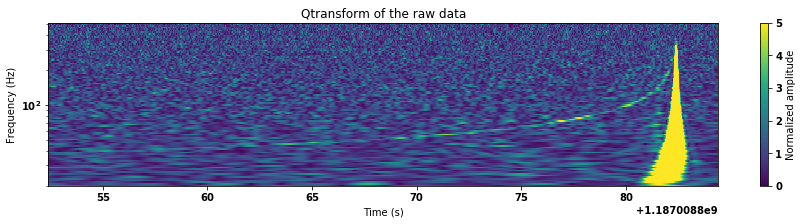

In [24]:
#qtransform of the data
white_sigP001 = (sigFP001/psdAP001**0.5).to_timeseries()
zoom = white_sigP001.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [25]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxAP001 = None
maxsnrAP001, m1maxAP001, m2maxAP001, tmaxAP001 = 0, 0, 0, 0

snrsAP001 = [[] for i in range(len(mass1))]
max_snrsAP001 = [[] for i in range(len(mass1))]
times_maxAP001 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP001.delta_f)
        hp.resize(len(sigFP001))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP001, psd = psdAP001, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsAP001[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsAP001[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxAP001[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrAP001:
            tmaxAP001, hmaxAP001, m1maxAP001, m2maxAP001, maxsnrAP001 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxAP001, m2maxAP001, tmaxAP001, maxsnrAP001))
print(merger.time)
print(timeBHP001)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 23.6571275
1187008882.4
1187008882.4117188


(1187008852.4, 1187008884.4)

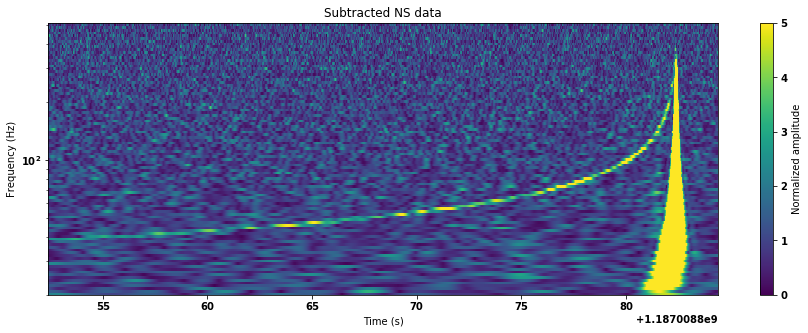

In [29]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxAP001 - sigFP001.start_time
inj = hmaxAP001.cyclic_time_shift(dt)

inj/= sigma(hmaxAP001, psd = psdAP001, low_frequency_cutoff = 20.)
inj *= maxsnrAP001

subFP001 = sigFP001 - inj

subT_wP001 = (subFP001/psdAP001**0.5).to_timeseries()
zoom = subT_wP001.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)


In [30]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxBP001 = None
maxsnrBP001, m1maxBP001, m2maxBP001, tmaxBP001 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigFP001.delta_f)
        hp.resize(len(sigFP001))
        
        snr = matched_filter(hp, sigFP001, psd = psdAP001, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrBP001:
            tmaxBP001, hmaxBP001, m1maxBP001, m2maxBP001, maxsnrBP001 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxBP001, m2maxBP001, tmaxBP001, maxsnrBP001))
print(timeBHP001)

mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 30.10, m2 = 30.10 at time 1187008882.4173341 with a value 181.4934772
1187008882.4117188


## For +0.05 s

In [32]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']


In [33]:
time_shifts = np.arange(218, 222, 0.01)

modelBHP005 = None
maxAmpBHP005, timeBHP005, time_difP005 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < 0.07) and (timeDif > 0.03) :
        print("in loop")
        modelBHP005 = hpInj
        maxAmpBHP005, timeBHP005, time_difP005 = max_amp, time_inj, timeDif

in loop
in loop
in loop
in loop


In [34]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBHP005)
print("The time of this maximum is: ", timeBHP005)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_difP005)

('The maximum amplitude of the injection is: ', 6.898225681153057e-21)
('The time of this maximum is: ', 1187008882.465674)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', 0.065673828125)


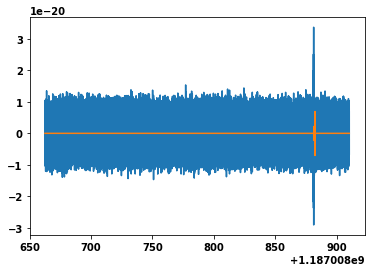

In [35]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBHP005.sample_times, modelBHP005, label = 'injection')

In [36]:
#addition of the two signals

sigP005 = strainL1 + modelBHP005

sigFP005 = sigP005.to_frequencyseries()

In [38]:
#psd of the added signal

pAP005 = sigP005.psd(2)
pAP005 = interpolate(pAP005, sigP005.delta_f)
psdAP005 = inverse_spectrum_truncation(pAP005, 2*sigP005.sample_rate,
                                  low_frequency_cutoff = 20.)

Text(0,0.5,'Normalized amplitude')

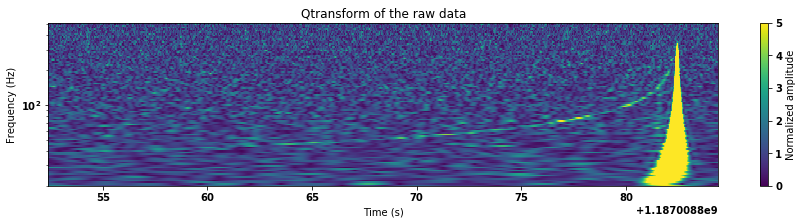

In [39]:
#qtransform of the data
white_sigP005 = (sigFP005/psdAP005**0.5).to_timeseries()
zoom = white_sigP005.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")


In [40]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxAP005 = None
maxsnrAP005, m1maxAP005, m2maxAP005, tmaxAP005 = 0, 0, 0, 0

snrsAP005 = [[] for i in range(len(mass1))]
max_snrsAP005 = [[] for i in range(len(mass1))]
times_maxAP005 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP005.delta_f)
        hp.resize(len(sigFP005))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP005, psd = psdAP005, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsAP005[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsAP005[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxAP005[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrAP005:
            tmaxAP005, hmaxAP005, m1maxAP005, m2maxAP005, maxsnrAP005 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxAP005, m2maxAP005, tmaxAP005, maxsnrAP005))
print(merger.time)
print(timeBHP005)


Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 24.1363475
1187008882.4
1187008882.465674


(1187008852.4, 1187008884.4)

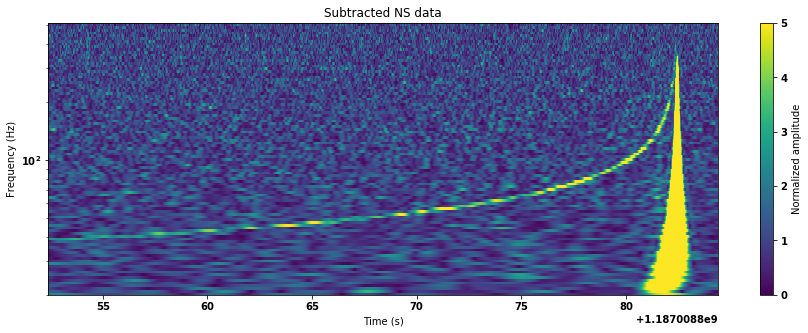

In [42]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxAP005 - sigFP005.start_time
inj = hmaxAP005.cyclic_time_shift(dt)

inj/= sigma(hmaxAP005, psd = psdAP005, low_frequency_cutoff = 20.)
inj *= maxsnrAP005

subFP005 = sigFP005 - inj

subT_wP005 = (subFP005/psdAP005**0.5).to_timeseries()
zoom = subT_wP005.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)


In [43]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxBP005 = None
maxsnrBP005, m1maxBP005, m2maxBP005, tmaxBP005 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigFP005.delta_f)
        hp.resize(len(sigFP005))
        
        snr = matched_filter(hp, sigFP005, psd = psdAP005, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrBP005:
            tmaxBP005, hmaxBP005, m1maxBP005, m2maxBP005, maxsnrBP005 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxBP005, m2maxBP005, tmaxBP005, maxsnrBP005))
print(timeBHP005)


mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 28.70, m2 = 31.60 at time 1187008882.4712892 with a value 182.9316679
1187008882.465674


The sutraction still works, even if the parameters of the black hole are slightly different

## For +0.1 s

In [44]:
#download of the data
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


strainL1 = strain['L1']
strainFL1 = stilde['L1']

In [47]:
time_shifts = np.arange(215, 220, 0.01)

modelBHP01 = None
maxAmpBHP01, timeBHP01, time_difP01 = 0, 0, 0

for t in time_shifts:
    hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 30,
                              mass2 = 30, distance = 100, f_lower = 20.,
                              delta_t = strainL1.delta_t)
    hpInj.resize(len(strainL1))
    hpInj = hpInj.cyclic_time_shift(t)
    hpInj.start_time = strainL1.start_time

    
    ind = hpInj.numpy().argmax()
    max_amp = hpInj[ind]
    time_inj = hpInj.sample_times[ind]
    timeDif = time_inj - merger.time
    #print(abs(timeDif))
    #print(abs(timeDif - 110))
    if (timeDif < 0.11) and (timeDif > 0.09) :
        print("in loop")
        modelBHP01 = hpInj
        maxAmpBHP01, timeBHP01, time_difP01 = max_amp, time_inj, timeDif

in loop
in loop


In [48]:
#info about the model
print("The maximum amplitude of the injection is: ", maxAmpBHP01)
print("The time of this maximum is: ", timeBHP01)
print("The time of the meger is: ", merger.time)
print("The time difference is: ", time_difP01)


('The maximum amplitude of the injection is: ', 6.878141910658568e-21)
('The time of this maximum is: ', 1187008882.505713)
('The time of the meger is: ', 1187008882.4)
('The time difference is: ', 0.105712890625)


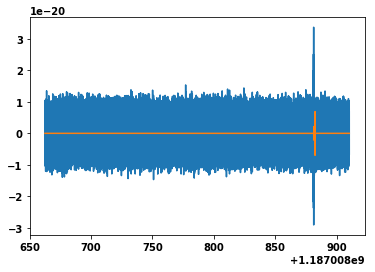

In [49]:
plt.plot(strainL1.sample_times, strainL1, label = 'strain')
plt.plot(modelBHP01.sample_times, modelBHP01, label = 'injection')

In [54]:
#addition of the two signals

sigP01 = strainL1 + modelBHP01

sigFP01 = sigP01.to_frequencyseries()

In [55]:
#psd of the added signal

pAP01 = sigP01.psd(2)
pAP01 = interpolate(pAP01, sigP01.delta_f)
psdAP01 = inverse_spectrum_truncation(pAP01, 2*sigP01.sample_rate,
                                  low_frequency_cutoff = 20.)

Text(0,0.5,'Normalized amplitude')

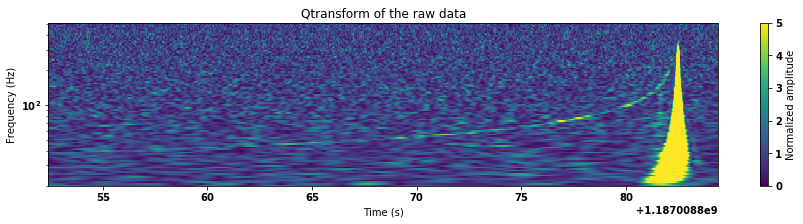

In [56]:
#qtransform of the data
white_sigP01 = (sigFP01/psdAP01**0.5).to_timeseries()
zoom = white_sigP01.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.title("Qtransform of the raw data")
plt.yscale('log')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.xlim(merger.time - 30, merger.time +2)
plt.ylim(0,512)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [58]:
#look for the NS signal

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmaxAP01 = None
maxsnrAP01, m1maxAP01, m2maxAP01, tmaxAP01 = 0, 0, 0, 0

snrsAP01 = [[] for i in range(len(mass1))]
max_snrsAP01 = [[] for i in range(len(mass1))]
times_maxAP01 = [[] for i in range(len(mass1))]

i = 0

for m1 in mass1:
    print("Mass1 : %i / %i" %(i+1, len(mass1)))
    for m2 in mass2:
        #waveform:
        hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal',
                                mass1 = m1, mass2 = m2, f_lower = 20.,
                                delta_f = sigFP01.delta_f)
        hp.resize(len(sigFP01))
        
        #do the max filtering
        snr = matched_filter(hp, sigFP01, psd = psdAP01, 
                             low_frequency_cutoff = 20.)
        snr.crop(10,10)
        
        #injection can be at more than 10 s f the merger. See
        #if signal can be found on a larger basis
        
        snr = snr.time_slice(merger.time - 120, merger.time + 25)
        snrsAP01[i].append(snr)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        max_snrsAP01[i].append(snrp)
        time = snr.sample_times[idx]
        times_maxAP01[i].append(time)
        
        #keep track of max snr
        if snrp > maxsnrAP01:
            tmaxAP01, hmaxAP01, m1maxAP01, m2maxAP01, maxsnrAP01 = time, hp, m1, m2, snrp
        
    i+=1
    print("Done")
    
print("We found the best masses m1 = %.3f and m2 = %.3f at the time %.7f with a SNR of %.7f" %(m1maxAP01, m2maxAP01, tmaxAP01, maxsnrAP01))
print(merger.time)
print(timeBHP01)

Mass1 : 1 / 22
Done
Mass1 : 2 / 22
Done
Mass1 : 3 / 22
Done
Mass1 : 4 / 22
Done
Mass1 : 5 / 22
Done
Mass1 : 6 / 22
Done
Mass1 : 7 / 22
Done
Mass1 : 8 / 22
Done
Mass1 : 9 / 22
Done
Mass1 : 10 / 22
Done
Mass1 : 11 / 22
Done
Mass1 : 12 / 22
Done
Mass1 : 13 / 22
Done
Mass1 : 14 / 22
Done
Mass1 : 15 / 22
Done
Mass1 : 16 / 22
Done
Mass1 : 17 / 22
Done
Mass1 : 18 / 22
Done
Mass1 : 19 / 22
Done
Mass1 : 20 / 22
Done
Mass1 : 21 / 22
Done
Mass1 : 22 / 22
Done
We found the best masses m1 = 1.480 and m2 = 1.280 at the time 1187008882.4454103 with a SNR of 24.0100276
1187008882.4
1187008882.505713


(1187008852.4, 1187008884.4)

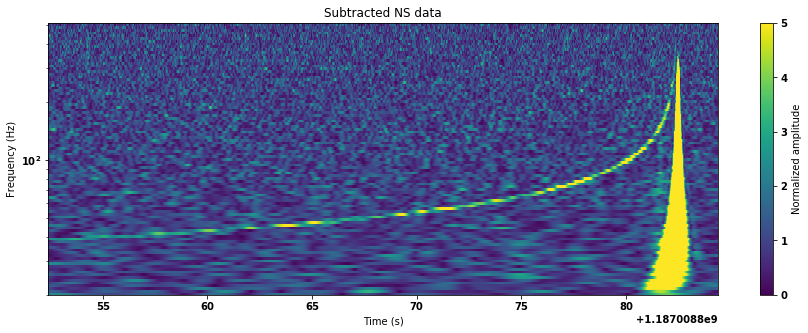

In [59]:
#trial of subtraction
from pycbc.filter import sigma

dt = tmaxAP01 - sigFP01.start_time
inj = hmaxAP01.cyclic_time_shift(dt)

inj/= sigma(hmaxAP01, psd = psdAP01, low_frequency_cutoff = 20.)
inj *= maxsnrAP01

subFP01 = sigFP01 - inj

subT_wP01 = (subFP01/psdAP01**0.5).to_timeseries()
zoom = subT_wP01.time_slice(merger.time - 32, merger.time + 10)
t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
plt.figure(figsize = [15,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Subtracted NS data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')
plt.xlim(merger.time - 30, merger.time +2)

In [61]:
#find time of the BBH merger
mass1 = np.arange(28, 32, 0.1)
mass2 = np.arange(28, 32, 0.1)

hmaxBP01 = None
maxsnrBP01, m1maxBP01, m2maxBP01, tmaxBP01 = 0, 0, 0, 0



i = 0

for m1 in mass1:
    print("mass 1 %i/%i" %(i+1, len(mass1)))
    for m2 in mass2:
        #generate a waveform
        hp, _ = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                               mass2 = m2, distance = 440, f_lower = 20., 
                                delta_f = sigFP01.delta_f)
        hp.resize(len(sigFP01))
        
        snr = matched_filter(hp, sigFP01, psd = psdAP01, 
                             low_frequency_cutoff = 20. )
        snr = snr.time_slice(merger.time - 120, merger.time + 10)
        idx = abs(snr).numpy().argmax()
        snrp = abs(snr[idx])
        time = snr.sample_times[idx]

        
        # Keep track of the max snr
        
        if snrp > maxsnrBP01:
            tmaxBP01, hmaxBP01, m1maxBP01, m2maxBP01, maxsnrBP01 = time, hp, m1, m2, snrp
            
    i +=1
    print("Done")
    
print("We found the best masses m1 = %.2f, m2 = %.2f at time %.7f with a value %.7f" %(m1maxBP01, m2maxBP01, tmaxBP01, maxsnrBP01))
print(timeBHP01)

mass 1 1/40
Done
mass 1 2/40
Done
mass 1 3/40
Done
mass 1 4/40
Done
mass 1 5/40
Done
mass 1 6/40
Done
mass 1 7/40
Done
mass 1 8/40
Done
mass 1 9/40
Done
mass 1 10/40
Done
mass 1 11/40
Done
mass 1 12/40
Done
mass 1 13/40
Done
mass 1 14/40
Done
mass 1 15/40
Done
mass 1 16/40
Done
mass 1 17/40
Done
mass 1 18/40
Done
mass 1 19/40
Done
mass 1 20/40
Done
mass 1 21/40
Done
mass 1 22/40
Done
mass 1 23/40
Done
mass 1 24/40
Done
mass 1 25/40
Done
mass 1 26/40
Done
mass 1 27/40
Done
mass 1 28/40
Done
mass 1 29/40
Done
mass 1 30/40
Done
mass 1 31/40
Done
mass 1 32/40
Done
mass 1 33/40
Done
mass 1 34/40
Done
mass 1 35/40
Done
mass 1 36/40
Done
mass 1 37/40
Done
mass 1 38/40
Done
mass 1 39/40
Done
mass 1 40/40
Done
We found the best masses m1 = 28.90, m2 = 31.40 at time 1187008882.5113282 with a value 182.7592316
1187008882.505713
